# **IMPORTS**

In [5]:
import scipy as sp
import pandas as pd
import numpy as np

import os
import itertools
import datetime
import json
import dill as pickle #более мощная библиотека позволяющая сохранять функции
import random
import copy

from IPython.display import display

from scipy.stats import kstest, anderson #lilliefors

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold 
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, roc_auc_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier


from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb, lightgbm as lgb, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter("ignore")

#import shap # Интерпритатор результатов деревянных моделей

%matplotlib inline
pd.set_option('display.max_columns', None)

%matplotlib inline

now_str = lambda : datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# **ФУНКЦИИ**

## **Расчета метрик и вывод результатов**

#### short_model_score_report

In [6]:
def short_model_score_report(y_true=[], y_pred=None, y_pred_proba=None, name='', display=True, header=True, model_type='classification'):
    
    # отчет для модели классификации
    if model_type == 'classification':
        
        if len(y_true) == 0:
            name = name
            f1 = ''
            pr = ''
            re = ''
            roc = ''
            gini = ''
            qty = 0
            y_true_rate = 0
        else:
            y_pred = np.round(y_pred_proba).astype('int')
            
            f1 = round(f1_score(y_true, y_pred),4)
            pr = round(precision_score(y_true, y_pred),4)
            re = round(recall_score(y_true, y_pred),4)
            roc = round(roc_auc_score(y_true, y_pred_proba),4) if (y_true.value_counts().shape[0] >1) else '-'
            gini = round(roc * 2 - 1, 4) if (roc !='-') else roc
            qty = len(y_true)
            y_true_rate = np.mean(y_true)
        
        if display:
            if header:
                print('\033[4m{:<40}{:>8}{:>8}{:>10}{:>10}{:>12}{:>10}{:>10}\033[0m'.format('Model', 'Qty', '1 %','f1 score', 'Recall', 'Precission', 'ROC AUC', 'Gini'))
            print('{:<40}{:>8}{:>8.2%}{:>10}{:>10}{:>12}{:>10}{:>10}'.format(name, qty, y_true_rate, f1, re, pr, roc, gini))
        else:
            return {'name':name,
                    'qty':qty,
                    'target_class_qty':np.sum(y_true),
                    'target_class_rate':y_true_rate,
                    'f1_score':f1,
                    'precision':pr,
                    'recall':re,
                    'ROC_AUC':roc,
                    'gini':gini} 
    
    
    # отчет для модели регрессии
    if model_type == 'regression':
        if len(y_true) == 0:
            name = name       
            mae = ''
            mse = ''
            rmse = ''
            r2 =  ''
            qty = 0
        else:
            mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
            rmse_err = lambda y, y_pred : mse_err(y, y_pred) ** 0.5
            mae_err = lambda y, y_pred : np.mean(np.abs(y - y_pred))
            r2_calc = lambda y, y_pred : 1 - mse_err(y, y_pred) / mse_err(y, np.mean(y))

            mae = round(mae_err(y_true, y_pred),4)
            mse = round(mse_err(y_true, y_pred),4)
            rmse = round(rmse_err(y_true, y_pred),4)
            r2 =  round(r2_calc(y_true, y_pred),4)
            qty= len(y_true)
        
        if display:
            if header:
                print('\033[4m{:<40}{:>10}{:>10}{:>10}{:>10}\033[0m'.format('Model', 'Qty', 'MAE', 'RMSE', 'R2'))
            print('{:<40}{:>10}{:>10}{:>10}{:>10}'.format(name, qty, mae, rmse, r2))
        else:
            return {'name':name,
                    'qty':qty,
                    'MAE':mae,
                    'MSE':mse,
                    'RMSE':rmse,
                    'r2_score':r2}

#### slice_report

In [7]:
def slice_report(df,                           # DataFrame with features columns from features_list
                 y_true,                       # y_true Series
                 y_proba=None,                 # Dictionary with predicted y probability {model_name:y_proba}
                 credit_amt=None,              # Размер кредита
                 slice_dict=None,              # Dictionaty with slices from dict to check metrics: {slice_name:slice_indexes}
                 feature_list=None,            # list of features to check metyrics 
                 score_splits=20,              # Кол-во бакетов в скор репорте
                 percentile_splits=20,         # Кол-во бакетов в репорте по процентилям
                 model_type='classification'): # Model type to get metrics from short_model_score_report
    
    report_metrics = list(short_model_score_report (model_type=model_type, display=False).keys())
    metrics_report = pd.DataFrame(columns=(['model', 'slice'] + feature_list + report_metrics))
    scoring_report_full = None
    
    
    if not slice_dict:
        slice_dict={'ALL_VALUES':df.index}
    
    dimentions_list = list(list(df[feature].value_counts().index) + ['ALL_VALUES'] for feature in feature_list)
    dimentions_list = list(itertools.product(*dimentions_list))

    for model in y_proba.keys():
        for slice_key in slice_dict.keys():
            
            for dimention in dimentions_list:

                slice_bunch_name = str(slice_key)
                slice_bunch_index = slice_dict[slice_key]

                for i in range(len(feature_list)):
                    slice_bunch_name += ' ' + feature_list[i] + '=' + str(dimention[i])

                    if dimention[i] == 'ALL_VALUES':
                        feature_value_index = slice_bunch_index
                    else:
                        feature_value_index = df.loc[df[feature_list[i]]==dimention[i]].index

                    slice_bunch_index = slice_bunch_index & feature_value_index              
                
                #формирование отчета по метрикам на слайсе по заданному срезу признаков
                slice_bunch_metrics = short_model_score_report(y_true=y_true.loc[slice_bunch_index],
                                                               y_pred_proba=y_proba[model].loc[slice_bunch_index],
                                                               name=slice_bunch_name,
                                                               header=True,
                                                               model_type=model_type,
                                                               display=False)
                #Запись отчета по метркам
                report_index = metrics_report.shape[0]
                slice_bunch_metrics_list = [slice_bunch_metrics[col] for col in slice_bunch_metrics.keys()]
                metrics_report.loc[report_index] = [model] + [slice_key] + list(dimention) + slice_bunch_metrics_list                                    
                
                
                #формирование отчето по скорам и персентилям                
                slice_bunch_report_score = scoring_report(y_true=y_true.loc[slice_bunch_index],
                                                          credit_amt=credit_amt.loc[slice_bunch_index],
                                                          y_proba=y_proba[model].loc[slice_bunch_index],
                                                          split_qty=score_splits,
                                                          min_scale=0,
                                                          max_scale=1000,
                                                          score_bucket=True,
                                                          value_report=False,
                                                          plot=False)
                
                slice_bunch_report_per_q = scoring_report(y_true=y_true.loc[slice_bunch_index],
                                                          credit_amt=credit_amt.loc[slice_bunch_index],
                                                          y_proba=y_proba[model].loc[slice_bunch_index],
                                                          split_qty=score_splits,
                                                          min_scale=0,
                                                          max_scale=1000,
                                                          score_bucket=False,
                                                          value_report=False,                                                          
                                                          plot=False)                
                
                slice_bunch_report_per_a = scoring_report(y_true=y_true.loc[slice_bunch_index],
                                                          credit_amt=credit_amt.loc[slice_bunch_index],
                                                          y_proba=y_proba[model].loc[slice_bunch_index],
                                                          split_qty=score_splits,
                                                          min_scale=0,
                                                          max_scale=1000,
                                                          score_bucket=False,
                                                          value_report=True,                                                          
                                                          plot=False)                  
                
                # Добавление к скоринговому отчету названия слайсов, модели значение признаков
                slice_bunch_report_score['report_type'] = 'score bucket'
                slice_bunch_report_per_q['report_type'] = 'percentile qty'
                slice_bunch_report_per_a['report_type'] = 'percentile amt'
                
                slice_bunch_report = pd.concat((slice_bunch_report_score.reset_index(),
                                                slice_bunch_report_per_q.reset_index(),
                                                slice_bunch_report_per_a.reset_index()),
                                                axis=0)
                
                slice_bunch_report['model'] = model
                slice_bunch_report['slice'] = slice_key
                slice_bunch_report['name'] = slice_bunch_name
                for j in range(len(feature_list)):
                    slice_bunch_report[feature_list[j]] = dimention[j]
                    
                scoring_report_full = pd.concat((scoring_report_full, slice_bunch_report), axis=0)

    return metrics_report, scoring_report_full

#### scoring_report

In [8]:
def scoring_report(y_true,
                   y_proba,
                   credit_amt=None,
                   split_qty=None,
                   min_scale=0,
                   max_scale=1000,
                   score_bucket=True,
                   value_report=False,
                   plot=False):
    
    # Корректировка входных данных на случай выбросов (FICO имеет большое кол-во скоров на границе диапазонов и случаются выбросы)
    y_proba[y_proba <= 0] = 0.1 / max_scale
    y_proba[y_proba >= 1] = 1 - 0.1 / max_scale
    
    if str(type(credit_amt)) == "<class 'NoneType'>":
        credit_amt = np.zeros(y_true.shape[0])
    else:
        credit_amt = credit_amt
    
    report = pd.DataFrame({'score': max_scale - y_proba * (max_scale - min_scale),
                           'target': y_true,
                           'credit_amt': credit_amt,
                           'risk_amt': credit_amt * y_true})
    
    report.sort_values(by='score', ascending=True, inplace=True)
    
    report.index = np.arange(report.shape[0])

    
    # Определение кол-во бакетов по умолчанию для разных видов отчетов
    if not split_qty:
        split_qty = 10 + 10 * bucket_type
    
    # Деление на бакеты в зависимости от типа отчета
    if score_bucket:
        report['bucket_cut_row'] = report['score']
        buckets = np.linspace(min_scale, max_scale, split_qty+1).astype('int')
        buckets_labels = buckets

    else:
        
        if y_true.shape[0] >= split_qty:
            if value_report:
                report['bucket_cut_row'] = np.cumsum(report['credit_amt'])
                
                if np.sum(report['credit_amt']) > 0:
                    buckets = np.linspace(0, np.sum(report['credit_amt']), split_qty + 1)
                else:
                    buckets = np.linspace(0, split_qty, split_qty + 1)
                
            else:
                report['bucket_cut_row'] = report.index
                buckets = np.percentile(report['bucket_cut_row'], np.linspace(0, 100, split_qty + 1))
        else:
            report['bucket_cut_row'] = report.index            
            buckets = np.linspace(0, split_qty, split_qty + 1)
        
        buckets = list(buckets)[:-1] + [list(buckets)[-1]+1]
        buckets_labels = np.linspace(0, 100, split_qty + 1).astype('int')
    
    report['bucket'] = pd.cut(report['bucket_cut_row'], right=False, bins=buckets, labels=buckets_labels[1:])
    
    # Формирование отчета
    report = report.groupby(by='bucket').agg({'score':len,
                                              'target':sum,
                                              'credit_amt':sum,
                                              'risk_amt':sum}).reset_index()
    
    report.columns = ['bucket', 'buckets_qty', 'risk_qty', 'buckets_amt', 'risk_amt']
    
    report['buckets_qty'].fillna(0, inplace=True)
    report['buckets_amt'].fillna(0, inplace=True)
    
    report['buckets_amt'] = report['buckets_amt'] / 1000000
    report['risk_amt'] = report['risk_amt'] / 1000000
    
    report['buckets_qty'] = report['buckets_qty'].astype('int')
    
    report['buckets_qty_%'] = report['buckets_qty'] / np.sum(report['buckets_qty']) * 100
    report['buckets_amt_%'] = report['buckets_amt'] / np.sum(report['buckets_amt']) * 100
    
    report['buckets_qty_cum'] = np.cumsum(report['buckets_qty'])
    report['buckets_amt_cum'] = np.cumsum(report['buckets_amt'])
    
    report['buckets_qty_cum_%'] = report['buckets_qty_cum'] / np.sum(report['buckets_qty']) * 100
    report['buckets_amt_cum_%'] = report['buckets_amt_cum'] / np.sum(report['buckets_amt']) * 100    
    
    report['risk_qty_cum'] = np.cumsum(report['risk_qty'])
    report['risk_amt_cum'] = np.cumsum(report['risk_amt'])
    
    report['risk_qty_portion_%'] = report['risk_qty'] / report['buckets_qty'] * 100
    report['risk_amt_portion_%'] = report['risk_amt'] / report['buckets_amt'] * 100
    
    report['risk_qty_portion_cum_%'] = report['risk_qty_cum'] / report['buckets_qty_cum'] * 100
    report['risk_amt_portion_cum_%'] = report['risk_amt_cum'] / report['buckets_amt_cum'] * 100    
    
    report['portion_of_ttl_risk_qty_cum_%'] = report['risk_qty_cum'] / np.sum(report['risk_qty']) * 100
    report['portion_of_ttl_risk_amt_cum_%'] = report['risk_amt_cum'] / np.sum(report['risk_amt']) * 100

    # Округление полей отчета
    for col in report.columns:
        if col[-1]=='%':
            report[col] = np.round(report[col], 2)
        elif col[-3:] == 'qty' or col[-7:] == 'qty_cum':
            report[col] = np.round(report[col], 0)
        elif col[-3:] == 'amt' or col[-7:] == 'amt_cum':
            report[col] = np.round(report[col], 2)
        else:
            report[col] = np.round(report[col], 0)

    # Словарь для перевода нименования ситолбцов на русский язык
    report_columns_dict = {'bucket':'Бакет',
                           'buckets_qty':'Кол-во',
                           'buckets_qty_cum':'Кол-во (ком)',
                           'buckets_qty_%':'Кол-во %',
                           'buckets_qty_cum_%':'Кол-во % (ком)',
                           'risk_qty':'Риск кол-во',
                           'risk_qty_cum':'Риск кол-во (ком)',
                           'risk_qty_portion_%':'Риск кол-во %',
                           'risk_qty_portion_cum_%':'Риск кол-во % (ком)',
                           'portion_of_ttl_risk_qty_cum_%':'Доля риска от всего риска кол-во % (ком)',
                           'buckets_amt':'Сумма (млн)',
                           'buckets_amt_cum':'Сумма (ком)',
                           'buckets_amt_%':'Сумма %',
                           'buckets_amt_cum_%':'Сумма % (ком)',
                           'risk_amt':'Риск сумма',
                           'risk_amt_cum':'Риск сумма (ком)',
                           'risk_amt_portion_%':'Риск сумма %',
                           'risk_amt_portion_cum_%':'Риск сумма % (ком)',
                           'portion_of_ttl_risk_amt_cum_%':'Доля риска от всего риска сумма % (ком)'}
    
    if plot and score_bucket:
        
        fig, ax = plt.subplots(ncols=2, nrows=2)
        fig.set_size_inches (18 , 12)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
        ax = ax.flatten()
            
        bar_width = (max_scale - min_scale) / split_qty * 0.9
        
        # Графики по кол-ву
        ax_02 = ax[0].twinx()
        ax_02.bar(x=report['bucket'], height=report['buckets_qty_%'], width=bar_width, label='Выдача (кол-во %)',  align='center', alpha=0.5)
        ax_02.set_ylabel('Выдача (кол-во %)')        
        ax_02.legend(loc='upper right') 
        ax_02.set_ylim([0, np.max(report['buckets_qty_%'])*1.2])
        
        ax_12 = ax[1].twinx()
        ax_12.bar(x=buckets_labels[1:], height=report['buckets_qty_cum_%'], width=bar_width, label='Выдача накопительно\n(кол-во %)', alpha=0.5)
        ax_12.set_ylabel('Выдача (кол-во %)')        
        ax_12.legend(loc='upper right') 
        ax_12.set_ylim([0, np.max(report['buckets_qty_cum_%'])*1.2])
    
        ax[0].plot(buckets_labels[1:], report['risk_qty_portion_%'], 'ro-',label='Риск (кол-во %)')
        ax[0].set_title('Распределение по бакетам (кол-во)')
        ax[0].set_xlabel('Скор-Бал')
        ax[0].set_ylabel('Риск %')
        ax[0].set_xticks(buckets_labels[1:])
        ax[0].set_ylim([0, np.max(report['risk_qty_portion_%'])*1.2])
        ax[0].legend(loc='upper left')
        ax[0].set_xticklabels(labels = buckets_labels, rotation = 45) 

        ax[1].plot(buckets_labels[1:], report['risk_qty_portion_cum_%'],'ro-', label='Риск накопительно \n(кол-во %)')
        ax[1].set_title('Накопительное распределение (кол-во)')
        ax[1].set_xlabel('Скор-Бал')
        ax[1].set_ylabel('Риск %')
        ax[1].set_xticks(buckets_labels[1:])
        ax[1].set_ylim([0, np.max(report['risk_qty_portion_cum_%'])*1.2])
        ax[1].legend(loc='upper left')
        ax[1].set_xticklabels(labels = buckets_labels, rotation = 45) 
        
        # Графики по сумме        
        ax_22 = ax[2].twinx()
        ax_22.bar(x=report['bucket'], height=report['buckets_amt_%'], width=bar_width, label='Выдача (сумма %)',  align='center', alpha=0.5)
        ax_22.set_ylabel('Выдача (сумма %)')        
        ax_22.legend(loc='upper right') 
        ax_22.set_ylim([0, np.max(report['buckets_amt_%'])*1.2])
        
        ax_32 = ax[3].twinx()
        ax_32.bar(x=buckets_labels[1:], height=report['buckets_amt_cum_%'], width=bar_width, label='Выдача накопительно\n(сумма %)', alpha=0.5)
        ax_32.set_ylabel('Выдача (сумма %)')        
        ax_32.legend(loc='upper right') 
        ax_32.set_ylim([0, np.max(report['buckets_amt_cum_%'])*1.2])
    
        ax[2].plot(buckets_labels[1:], report['risk_amt_portion_%'], 'ro-',label='Риск (сумма %)')
        ax[2].set_title('Распределение по бакетам (сумма)')
        ax[2].set_xlabel('Скор-Бал')
        ax[2].set_ylabel('Риск %')
        ax[2].set_xticks(buckets_labels[1:])
        ax[2].set_ylim([0, np.max(report['risk_amt_portion_%'])*1.2])
        ax[2].legend(loc='upper left')
        ax[2].set_xticklabels(labels = buckets_labels, rotation = 45) 

        ax[3].plot(buckets_labels[1:], report['risk_amt_portion_cum_%'],'ro-', label='Риск накопительно \n(сумма %)')
        ax[3].set_title('Накопительное распределение (сумма)')
        ax[3].set_xlabel('Скор-Бал')
        ax[3].set_ylabel('Риск %')
        ax[3].set_xticks(buckets_labels[1:])
        ax[3].set_ylim([0, np.max(report['risk_amt_portion_cum_%'])*1.2])
        ax[3].legend(loc='upper left')
        ax[3].set_xticklabels(labels = buckets_labels, rotation = 45) 
        
        
    if plot and not score_bucket:
        
        fig, ax = plt.subplots(ncols=1, nrows=1)
        fig.set_size_inches (11 , 5)
        plt.subplots_adjust(wspace=0.2, hspace=0.3)
        
        if value_report:
            bar_series = 'portion_of_ttl_risk_amt_cum_%'
            line_1_series = 'risk_amt_portion_%'
            line_1_label = 'Риск (сумма %)'
            line_2_series = 'risk_amt_portion_cum_%'
            line_2_label = 'Риск накопительно (сумма %)'
        else:
            bar_series = 'portion_of_ttl_risk_qty_cum_%'
            line_1_series = 'risk_qty_portion_%'
            line_1_label = 'Риск (кол-во %)'
            line_2_series = 'risk_qty_portion_cum_%'
            line_2_label = 'Риск накопительно (кол-во %)'
        
        bar_width = 100 / split_qty * 0.9
        
        ax_2 = ax.twinx()
        ax_2.bar(x=buckets_labels[1:], height=report[bar_series], width=bar_width, label='Доля риска от всего риска % (ком)', alpha=0.5, color='grey')
        #ax_2.plot(buckets_labels[1:], report['portion_of_ttl_risk_cum_%'],'bo-', label='Доля риска от всего риска % (ком)')
        ax_2.set_ylabel('Доля риска от всего риска %')        
        ax_2.legend(loc='upper right') 
        ax_2.set_ylim([0, np.max(report[bar_series])*1.2])
   
        ax.plot(buckets_labels[1:], report[line_1_series], 'ro-',label=line_1_label)
        ax.plot(buckets_labels[1:], report[line_2_series],'go-', label=line_2_label)
        ax.set_title('Распределение по персентилям')
        ax.set_xlabel('Персентиль выдач')
        ax.set_ylabel('Риск %')
        ax.set_xticks(buckets_labels[1:])
        ax.set_ylim([0, np.max(report[[line_1_series, line_2_series]].stack())*1.2])
        ax.legend(loc='upper left')
        ax.set_xticklabels(labels = buckets_labels, rotation = 45) 
    
    # Упорядочивание колонок
    report = report[report_columns_dict.keys()]              

    # Переименоване столбцов отчета на русский язык перед выводом
    report.columns = [report_columns_dict[col] for col in report.columns]

    report.set_index('Бакет', inplace=True)
    
    return report

#### report_by_product

In [9]:
# Оценка Качество предсказаний модели в разрезе продуктов и повторных/новых заемщиков
def report_by_product(df, y_true, y_proba):
    
    if 'NEW_REPEAD' in df.columns:
        df['REPEAT_CNT'] = df['NEW_REPEAD']
    
    if 'PRODUCT' in df.columns:
        df['ACCT_TYPE'] = df['PRODUCT']
    
    
    segments = [('ВСЕ ЗАЕМЩИКИ', df),
                ('ПОВТОРНЫЕ', df.loc[(df['REPEAT_CNT'] > 0)]),
                ('НОВЫЕ', df.loc[(df['REPEAT_CNT'] == 0)])]

    for segment_name, segment_df in segments:
        print('\n'+segment_name)
        for prod in df['ACCT_TYPE'].unique():
            prod_index =  segment_df.loc[segment_df['ACCT_TYPE'] == prod].index
            if prod_index.shape[0]>0:
                short_model_score_report(y_true=y_true.loc[prod_index],
                                         y_pred_proba=y_proba.loc[prod_index],
                                         name=product_dict.get(prod) +' (' + str(int(prod)) +')',
                                         header=(prod == df['ACCT_TYPE'].unique()[0]),
                                         model_type=model_type)
        prod_index =  segment_df.index
        short_model_score_report(y_true=y_true.loc[prod_index],
                                 y_pred_proba=y_proba.loc[prod_index],
                                 name='Все продукты',
                                 header=False,
                                 model_type=model_type)

## **Исследование данных**

#### distribution_by_target

In [10]:
def distribution_by_target(df, TARGET_NAME, model_type='classification'):
    
    ci =95 # confidense interval
    col_lst = list(df.drop(columns=TARGET_NAME).select_dtypes(exclude=['object']).columns)

    fig, ax = plt.subplots(nrows=len(col_lst), ncols=3)
    
    fig.set_size_inches (21 , len(col_lst) * 5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        
        if model_type == 'classification':
            sns.kdeplot(df.loc[df[TARGET_NAME] == 0, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax[i*3])
            sns.kdeplot(df.loc[df[TARGET_NAME] == 1, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax[i*3])
            ax[i*3].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
            ax[i*3].legend()

            sns.pointplot(x=TARGET_NAME, y=col_lst[i], data=df[[TARGET_NAME, col_lst[i]]], capsize=.1, ci=ci, ax=ax[i*3+1]);
            ax[i*3+1].set_title('Confidence intervals ('+ str(ci) + ' %) for ' + col_lst[i])
        
        if model_type == 'regression':
            sns.kdeplot(df[col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label=col_lst[i] + '  density', ax=ax[i*3])
            ax[i*3].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
            ax[i*3].legend()

            ax[i*3+1].scatter(y=df[col_lst[i]], x=df[TARGET_NAME])
            ax[i*3+1].set_title(col_lst[i] + ' by ' + TARGET_NAME)
            
        cor = np.abs(df.corr()[col_lst[i]]).sort_values(ascending=False)[1:]
        sns.barplot(x=cor[:6], y=cor.index[:6], ax=ax[i*3+2])
        ax[i*3+2].set_title('Top cor features (abs)')

#### categorization_by_target

In [11]:
# В случае регрессии необходимо заменить частоты на boxtype - диапазоны для выявления закономерностей
def categorization_by_target(df, TARGET_NAME, column, sort_by='class', max_len=50, model_type='classification'):
    df_tmp = df.copy()
    #col_lst = df_tmp.drop([TARGET_NAME], axis=1).select_dtypes(include=['object']).columns
    col_lst = [column]
    df_tmp[col_lst] = df_tmp[col_lst].astype('str')
    
    fig, ax = plt.subplots(nrows=len(col_lst), ncols=3)
    fig.set_size_inches (14, min(df[column].nunique(), max_len)*0.5)
    plt.subplots_adjust(wspace=0.5)
    ax = ax.flatten()
    ax[1].remove()
    ax[0] = plt.subplot2grid((1,3), (0,0), colspan=2)
    
    for i in range(1):
        col = col_lst[i]
        data = df_tmp.groupby(by=col).agg({TARGET_NAME: [sum, len]})
        data['1'] = data[(TARGET_NAME, 'sum')]
        data['ttl'] = data[(TARGET_NAME, 'len')]
        data['1%'] =  data['1'] / data['ttl']
        data['0%'] =  1 - data['1%']
        data['weight'] = data['ttl'] / df_tmp.shape[0]
        if sort_by=='class':
            data = data.sort_values(by=['1%'])
        elif sort_by=='weight':
            data = data.sort_values(by=['weight'])
        elif sort_by=='label':  
            data = data.sort_index()
        
        data = data.iloc[max(data.shape[0] - max_len,0):,:]
        
        ax[0].barh(range(data.shape[0]), data['0%'], label='0')
        ax[0].barh(range(data.shape[0]), data['1%'], label='1', left=data['0%'])    
        ax[0].set_xlabel('Portion of class, %')
        ax[0].set_title('Target distribution by "' + col + '"')
        ax[0].set_xticks(np.linspace(0, 1, 11))
        
        ax[0].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['1%'] * 100, 1)).astype('str') + '%\n' + data.index.astype('str')
        ax[0].set_yticklabels(y_ticks)

        ax[0].legend(title=TARGET_NAME)
        ax[0].axvline(df_tmp.loc[df_tmp[TARGET_NAME]==0].shape[0] / df_tmp.shape[0], c='r')
        
        ax[2].barh(range(data.shape[0]), round(data['ttl'] / df_tmp.shape[0] * 100, 1), label='Weight', height=0.8)
        ax[2].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['ttl'] / df_tmp.shape[0] * 100, 1)).astype('str') + '% - ' + data['ttl'].astype('str') + '\n' + data.index.astype('str')
        ax[2].axvline(100/ df_tmp[column].nunique(), c='r')
        ax[2].set_yticklabels(y_ticks)
        ax[2].legend()

#### heatmap

In [12]:
def heatmap(df):
    plt.figure(figsize = (1 * df.shape[1], 0.5 * df.shape[1]))
    sns.set(font_scale=1)
    sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

#### feature_generation

In [13]:
# Генерация новых признаков путем умножения и деления и вывод наиболее корелирующих с целевой переменной
def feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.15, hi_limit=0.15, plot_cor=False, powers=[-1, 2]):  
    
    # Подфункция проверки уровня корреляции и добавления в массив
    def add_hi_cor_feature(col_name, col_values, col_values_test):
        cor = df[[TARGET_NAME]].corrwith(other=col_values)[0]
        if (cor >= hi_limit) or (cor <= lo_limit):
            df_tmp[col_name] = col_values
            df_tmp[col_name] = df_tmp[col_name].fillna(np.mean(col_values))
            df_test_tmp[col_name] = col_values_test
            df_test_tmp[col_name] = df_test_tmp[col_name].fillna(np.mean(col_values_test))
    
    df_tmp=df.drop(columns=TARGET_NAME).copy()
    df_test_tmp = df_test.copy()
    
    num_col_lst = df_tmp.select_dtypes(exclude=['O']).columns
    
    for i in range(len(num_col_lst)):
        # Проверка уровня корреляции признака в разной степени
        for power in powers:
            add_hi_cor_feature(num_col_lst[i] + ' ** (' + str(power) +')', df[num_col_lst[i]].astype('float') ** power, df_test[num_col_lst[i]].astype('float') ** power)
        
        # Проверка уровня корреляции логорифмированного признак                
        add_hi_cor_feature('LOG '+ num_col_lst[i], np.log(df[num_col_lst[i]]), np.log(df_test[num_col_lst[i]]))  
        
        for j in range(len(num_col_lst)):
            # Проверка уровня корреляции результатов деления признаков
            if i != j:
                col_name = num_col_lst[j] +' / '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] / df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] / df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
            
            # Проверка уровня корреляции результатов умножения признаков
            if j > i:
                col_name = num_col_lst[j] +' * '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] * df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] * df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
    
    if plot_cor:
        cor = df_tmp.drop(columns=num_col_lst).corrwith(other=df[TARGET_NAME]).sort_values()
        plt.figure(figsize=(15, cor.shape[0]*0.4))
        sns.barplot(x=cor, y=cor.index)
        plt.title('Correlation with target variable')
        plt.show();
    
    df_tmp[TARGET_NAME] = df[TARGET_NAME]
    
    return df_tmp, df_test_tmp

# **КЛАСС МОДЕЛИ**

In [14]:
# Класс модели

# Балансировка данных (для классификации)
# Предобработка и Масштабирование данных
# Разбивка на фолды
# Обучение моделей
# расчет предсказаний (валидационный и тетовый датасет) и запись в журнал

class bank_90_model_dev:
    
    # Класс масштабирования данных (аналог StandardScaler и MinMaxScaler)
    class scaler:

        def __init__(self, scaler_type='std'):
            self.scaler_type = scaler_type
            self.min = 0
            self.max = 0
            self.std = 0
            self.mean = 0

        def fit(self, data):
            self.min = np.min(data, axis=0)
            self.max = np.max(data, axis=0)
            self.std = np.std(data, axis=0)
            self.mean = np.mean(data, axis=0)
            return self

        def train(self, data):
            fit(self, data)

        def transform (self, data):
            if self.scaler_type == 'std':
                return self.compact_types((data - self.mean) / self.std)

            if self.scaler_type == 'norm':
                return self.compact_types((data - self.min) / (self.max-self.min))

            if self.scaler_type == 'none':
                return data

        def fit_transform(self, data):
            fit(self, data)
            transform (self, data)

        def compact_types(self, data):
            cols = data.select_dtypes(include='float64').columns
            data[cols] = data[cols].astype('float32')
            data.replace({-np.inf:np.nan, np.inf:np.nan}, inplace=True)
            return data
    
    def __init__(self,
                 df,                                   # датасет
                 TARGET_NAME,                          # Имя столбца с целевой переменной
                 model_type='classification',          # тип модели :  'classification', 'regression'
                 models={},                            # словарь моделей (обязательно  должны быть методы fit, predict)   
                 cat_columns=[],                       # Названия столбцов с категориальными признакми
                 scaler_columns=[],                    # Названия столбцов по которым необходимо проводить масштабирование
                 scaler_type = 'std',                  # Тип масштабирования признаков ('none', 'std', 'norm')
                 target_class_ratio=0.5,               # коэффициент для балансровки соотношения классов целевой переменной
                 downsample = False,                   # при щначении True балансирвка осуществляется через downsampling 
                 SKF_splits=5,                         # кол-во фолдов для валидации
                 strat_layers_qty=10,                  # Кол-во слоев для стратификации датасета по целевой переменной при применении k-fold
                 catb_sample_weight=True,              # указание веса каждого наблюдения для модели CatboostClassifier 
                 random_state=42):                     # Random_State
        
        self.version = '5'
        
        self.df = df
        self.df_bl_index = None
        self.df_bl_pr = None
        
        self.df_columns = list(df.columns)
        self.model_columns = None
        self.cat_columns = cat_columns
        
        self.scaler_columns = scaler_columns
        self.scaler_type = scaler_type

        self.target_class_ratio = target_class_ratio
        self.downsample = downsample

        self.SKF_splits = SKF_splits
        self.SKF_list = None
        self.strat_layers_qty = strat_layers_qty

        self.catb_sample_weight = catb_sample_weight

        self.random_state = random_state

        self.model_type = model_type
        self.TARGET_NAME = TARGET_NAME
        self.models = []
        
        for model in models.keys():
            self.models.append({'model_name':model,
                                'model_class':models[model].__class__.__name__,
                                'model_sample':models[model].copy(),
                                'feature_importance':None,
                                'folds':[{'fold':i+1,
                                          'scaler':None,
                                          'trained_model':None,
                                          'feature_prediction_values_change':None,                                                
                                          'feature_loss_function_change':None,
                                          'feature_interaction_importance':None} for i in range(SKF_splits)]})


    # Тренировка моделей
    def fit(self, 
            fold_report=True,         # Вывод репорта для каждого фолда
            train_report=False):      # Вывод репорта для тренировочного датасета
        
        now_str = lambda : datetime.datetime.now().strftime("%H:%M:%S")        

        # Формирование датасета для записи результатов работы моделей
        self.train_result = self.df[[self.TARGET_NAME]]
        for model in self.models:
            self.train_result[model['model_name']] = float("NaN")
            self.train_result[model['model_name'] + '_p'] =  float("NaN")

        # Балансировка по целевому классу (работает только для моделей классификации и формирует массив индексов отбалонсированного датасета)
        self.balance_df_by_target()
        
        # Предобработка данных функцией
        self.df_bl_pr = self.data_processing(self.df.loc[self.df_bl_index])
        
        # Фиксирование набора колонок для модели
        self.model_columns = list(self.df_bl_pr.drop(columns = self.TARGET_NAME))
        self.cat_columns = list(set(self.cat_columns) & set(self.model_columns))
        self.scaler_columns = list(set(self.scaler_columns) & set(self.model_columns))
        
        # Формирование индексов фолдоф для кроссвалидции
        self.SKF(df=self.df_bl_pr)
        
        split = 0
        for train_index, valid_index in self.SKF_list:
            split += 1
            
            # Формирование массивов для обучения и валидации модели
            df_train_pr = self.df_bl_pr.loc[train_index].copy()
            df_valid_pr = self.df_bl_pr.loc[valid_index].copy()
            
            # Масштабирование данных для моделей (критично для линейных моделей)
            df_train_pr_sc = df_train_pr
            df_valid_pr_sc = df_valid_pr
            
            data_scaler = self.scaler(scaler_type=self.scaler_type).fit(df_train_pr[self.scaler_columns])

            df_train_pr_sc[self.scaler_columns] = data_scaler.transform(df_train_pr[self.scaler_columns])
            df_valid_pr_sc[self.scaler_columns] = data_scaler.transform(df_valid_pr[self.scaler_columns])
            
            X_train = df_train_pr_sc.drop(columns=TARGET_NAME)
            y_train = df_train_pr_sc[TARGET_NAME]

            X_valid = df_valid_pr_sc.drop(columns=TARGET_NAME)
            y_valid = df_valid_pr_sc[TARGET_NAME]
            
            # Удаление ненужных объектов
            del(df_train_pr)
            del(df_train_pr_sc)
            del(df_valid_pr)
            del(df_valid_pr_sc)

            #Тренировка моделей
            for model in self.models:

                model_name = model['model_name']
                model_to_train = model['model_sample'].copy()

                cat_feat_idx = list(np.where(X_train.columns.isin(self.cat_columns))[0])
                
                if model['model_class'] == 'CatBoostClassifier':

                    # Реализация балансировки по целевому классу для 'CatBoostClassifier'
                    if self.catb_sample_weight:
                        class_weight_dict = dict(1 / (y_train.value_counts()/y_train.shape[0]))
                        sample_weight = y_train.map(class_weight_dict)
                    else:
                        sample_weight = np.ones(y_train.shape[0])

                    catb_valid_pool=catb.Pool(data=X_valid, label=y_valid, cat_features=cat_feat_idx)
                    
                    model_to_train.fit(X_train, y_train, eval_set=catb_valid_pool, cat_features=cat_feat_idx, sample_weight=sample_weight, plot=False, use_best_model=True)

                    #Запись важности факторов на валидационном датасете в модель
                    model['folds'][split-1]['feature_prediction_values_change'] = model_to_train.get_feature_importance(data=catb_valid_pool)
                    model['folds'][split-1]['feature_loss_function_change'] = model_to_train.get_feature_importance(type='LossFunctionChange', data=catb_valid_pool)
                    model['folds'][split-1]['feature_interaction_importance'] = model_to_train.get_feature_importance(type='Interaction', data=catb_valid_pool)

                elif model['model_class'] == 'CatBoostRegressor':            
                    model_to_train.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_feat_idx, plot=False, use_best_model=True)

                else:
                    X_train.fillna(0, inplace=True)
                    X_valid.fillna(0, inplace=True)
                    model_to_train.fit(X_train, y_train)

                #Сохранение натренированной модели для каждого фолда
                model['folds'][split-1]['scaler'] = copy.deepcopy(data_scaler)
                model['folds'][split-1]['trained_model'] = copy.deepcopy(model_to_train)
                
                # Запись предсказаний моделей в журнал
                if model_type == 'classification':
                    y_valid_pred_proba = model_to_train.predict_proba(X_valid)[:,1]
                    y_valid_pred = np.round(y_valid_pred_proba).astype(int)
                    self.train_result.loc[valid_index, model_name + '_p'] = y_valid_pred_proba
                    self.train_result.loc[valid_index, model_name] = y_valid_pred

                elif model_type == 'regression':
                    y_valid_pred_proba = np.zeros(X_valid.shape[0])
                    y_valid_pred = model_to_train.predict(X_valid)
                    self.train_result.loc[valid_index, model_name] = y_valid_pred

                # Формирование и вывод отчета по фолду
                if fold_report:
                    if (model_name == self.models[0]['model_name']):
                        print('\nFOLD ' + str(split) + ' REPORT')

                    short_model_score_report(y_true=y_valid, 
                                             y_pred_proba=y_valid_pred_proba, 
                                             name=model_name + '_' +str(split) + '_valid', 
                                             header=(model_name == self.models[0]['model_name']),
                                             model_type=self.model_type)

                    # Расчет и вывод отчета для тренировочных данных
                    if train_report:
                        short_model_score_report(y_true=y_train, 
                                                 y_pred_proba=model_to_train.predict_proba(X_train)[:,1], 
                                                 name=len(model_name + '_' +str(split)) * ' ' + ' train',
                                                 model_type=self.model_type)

        
        # Вывод финального отчета
        print('\nFINAL REPORT ({} folds AVG)'.format(self.SKF_splits))
        slice_index = self.df_bl_index
        
        # Результат каждой из моделей на всех фолдах 
        for model in self.models:

            short_model_score_report(y_true=self.train_result[self.TARGET_NAME].loc[slice_index],
                                     y_pred_proba=self.train_result[model['model_name']+'_p'].loc[slice_index],
                                     name=model['model_name'],
                                     header=(model['model_name'] == self.models[0]['model_name']),
                                     model_type=self.model_type)
        
        # Усредненный результат всех моделей
        y_valid = self.df[self.TARGET_NAME].loc[slice_index]
        y_valid_pred_proba = np.sum(self.train_result[[model['model_name'] + '_p' for model in self.models]],axis=1) / len(self.models)
        y_valid_pred_proba = y_valid_pred_proba.loc[slice_index]
        
        if self.model_type == 'classification':
            y_valid_pred = np.round(y_valid_pred_proba).astype(int)

        elif self.model_type == 'regression':
            y_valid_pred = np.sum(self.train_result[[model['model_name']  for model in self.models]],axis=1) / len(self.models)

        short_model_score_report(y_true=y_valid,
                                 y_pred_proba=y_valid_pred_proba,
                                 name='MIX RESULT ',
                                 header=False,
                                 model_type=self.model_type)

        # Расчет скора и финальной вероятности по всем моделям
        p_cols = [col for col in self.train_result.columns if col[-2:]=='_p']
        self.train_result['proba'] = np.sum(self.train_result[p_cols], axis=1)
        self.train_result['score'] = 1000 - np.sum(self.train_result[p_cols], axis=1) * 1000

        # Расчет результатов для строк не вошедших в отбалансированный датасет
        unscored_result = self.predict(input_type='df', input_data=self.df[~self.df.index.isin(self.df_bl_index)], output_type='df')
        self.train_result.loc[unscored_result.index, unscored_result.columns] = unscored_result
        #self.train_result[~self.df.index.isin(self.df_bl_index)] = self.predict(input_type='df', input_data=self.df[~self.df.index.isin(self.df_bl_index)], output_type='df')
        #self.train_result[self.TARGET_NAME] = self.df[self.TARGET_NAME]
        
        # Расчет усреденнной важности признаков для моделей
        for model in self.models:
            if model['model_class'] == 'CatBoostClassifier':
                model['feature_importance'] = self.catb_feature_importance(model)

        
        # Удаление временных переменных
        self.df = None
        self.df_bl_pr = None
        del(unscored_result)
        del(X_valid)
        del(X_train)
        del(y_valid)
        del(y_train)
        del(y_valid_pred)
        del(y_valid_pred_proba)

        
    # Функция обработки данных (чистка данных, трансформация и дабавление признаков)
    def data_processing(self, df):
        
        if 'REGION_REG' in df.columns:
            df['REGION_REG'].fillna(0, inplace=True)
            df['REGION_REG'] = df['REGION_REG'].astype('int')

        if 'REGION_PR' in df.columns:
            df['REGION_PR'].fillna(0, inplace=True)
            df['REGION_PR'] = df['REGION_PR'].astype('int')

        if 'GENDER' in df.columns:
            df['GENDER'].fillna(1, inplace=True)
            df['GENDER'] = df['GENDER'].astype('int')

        return df

    
    # Метод формирования предсказания     
    def predict(self,
                input_type='df',         # 'df', 'csv', 'json', 'json_file'
                input_data=None,         # объект 'df',название файла 'csv', Строка 'json', файл с 'json' строками 
                output_type='df',        # 'df', 'json', 'csv'
                output_file_name=None):  # название файла в случае если output_type=='csv'

        # Формирование предсказания из входного датафрейма и контейнера с моделями
        def predict_from_df(df_test):

            model_name_lst = [model['model_name'] for model in self.models]

            # Формирование датасета для записи результатом работы моделей
            df_test_result = pd.DataFrame(index=df_test.index)
            
            #Обработка данных функцией и выстраивание одинаковой очередности и кол-ва признаков                
            df_test_pr = self.data_processing(df_test)[self.model_columns]
            
            for model in self.models:
                # Формирование дополнительныъ колонок для записи результатом работы моделей
                df_test_result[model['model_name']] = np.zeros(df_test.shape[0])
                df_test_result[model['model_name'] + '_p'] = np.zeros(df_test.shape[0])    

                for fold in model['folds']:

                    data_scaler = fold['scaler']
                    tr_model = fold['trained_model']

                    # Масштабирование данных для моделей (критично для линейных моделей)
                    df_test_pr_sc = df_test_pr.copy()
                    df_test_pr_sc[self.scaler_columns] = data_scaler.transform(df_test_pr[self.scaler_columns])
                    X_test = df_test_pr_sc
                    
                    # Обработка пропусков
                    if model['model_class'] != 'CatBoostClassifier':
                        X_test.replace({-np.inf:0, np.inf:0, np.nan:0}, inplace=True)

                    # Запись предсказаний моделей в журнал
                    if self.model_type == 'classification':
                        y_pred_proba = tr_model.predict_proba(X_test)[:,1]
                        df_test_result[model['model_name'] + '_p'] += y_pred_proba
                        df_test_result[model['model_name']] += np.round(y_pred_proba)
                    else:
                        df_test_result[model['model_name']] += tr_model.predict(X_test)
                    
                df_test_result = df_test_result / len(model['folds'])

            # Округление до 0 знаков среднего значения предскзаний модели на всех фолдах 
            if self.model_type == 'classification':
                df_test_result[model_name_lst] =  np.round(df_test_result[model_name_lst]).astype(int)
                p_cols = [col for col in df_test_result.columns if col[-2:]=='_p']
                df_test_result['proba'] = np.sum(df_test_result[p_cols], axis=1)
                df_test_result['score'] = 1000 - np.sum(df_test_result[p_cols], axis=1) * 1000

            return df_test_result

        
        # на входе строка JSON с данными для формирования предсказания
        def predict_from_json(df_json):
            df_dict = json.loads(df_json)

            # Формирование датафрейма
            df = pd.read_json(json.dumps(df_dict['data'])[1:-1], orient='records', lines=True)

            # Формирование предсказаний
            df_pred = predict_from_df(df.set_index('dataItemId'))

            return df_pred

        
        # на входе файл JSON с данными для формирования предсказания
        def predict_from_json_file(file_name):
            read_stdin = ''
            open_counter = 0
            json_counter = 0
            pred =pd.DataFrame()

            with open(file_name, 'r') as stdandar_input:
                for line in stdandar_input:
                    for s in line:
                        open_counter += (s == '{')
                        open_counter -= (s == '}')
                        read_stdin += s
                        if open_counter == 0:
                            if read_stdin[0] == '{':
                                json_counter += 1
                                if pred.shape[0] ==0 :
                                    pred = predict_from_json(df_json=read_stdin)
                                else:
                                    pred = pd.concat([pred, predict_from_json(df_json=read_stdin)], axis=0)
                            read_stdin = ''
            return pred

        #Обработка входных данных
        if input_type == 'df':
            df_result = predict_from_df(input_data)

        elif input_type == 'csv':
            with open(input_data, encoding='utf8') as f:
                h = f.readline()
            if h.count(';')>0: 
                df_result = predict_from_df(pd.read_csv(input_data,';'))
            else:
                df_result = predict_from_df(pd.read_csv(input_data,','))
            
            
        elif input_type == 'json':
            df_result = predict_from_json(input_data)

        elif input_type == 'json_file':
            df_result = predict_from_json_file(input_data)

        #Вывод результата
        if output_type == 'df':
            return df_result

        if output_type == 'json':                                     

            #функция преобразоваиня типов для конвертации в JSON
            def convert_to_json_type(x):
                if str(type(x))[:-4] == "<class 'numpy.int":
                    x = int(x)
                elif str(type(x))[:-4] == "<class 'numpy.float'>":
                    x = float(x)
                else:
                    x = str(x) 
                return x

            df_result.reset_index(inplace=True)
            cols = list(df_result.columns)

            pred_dict = {'version': self.version, 
                         'data': [{col: convert_to_json_type(df_result[col].values[i]) for col in cols} for i in range(df_result.shape[0])]}

            return json.dumps(pred_dict)    

        if output_type == 'csv':
            df_result.to_csv(output_file_name)
            return 'Данные экспортированы в файл: ' + output_file_name

    # Разбивка на фолды стратифицированная по значению целевой переменной
    def SKF(self, df):
        TARGET_NAME = self.TARGET_NAME
        n_splits = self.SKF_splits
        max_layers_qty = self.strat_layers_qty
        random_state = self.random_state
        
        if n_splits==1:
            return [[np.array(df.index), np.array(df.index)]]

        # Определение кол-ва слоев
        layers_qty = min(max_layers_qty, np.unique(df[TARGET_NAME]).shape[0])
        # Определение значения целевой переменной для разбивки на слои
        split_points = np.linspace(np.min(df[TARGET_NAME]), np.max(df[TARGET_NAME]), layers_qty+1)
        #split_points = np.quantile(np.sort(np.unique(df[TARGET_NAME])), np.linspace(0, 1, layers_qty+1))

        # Формирование списка со значениями индексов слоев и списка содержащего фолды для тренировки и валидации
        layers=[]
        SKF_list = [[np.array([]),np.array([])] for i in range(n_splits)]

        np.random.seed(random_state) 

        for i in range(len(split_points)-1):
            # Определение индекса элементов входящих в слой
            if i == len(split_points)-2:
                layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]<=split_points[i+1])].index)
            else:
                layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]< split_points[i+1])].index)

            np.random.shuffle(layer_index)
            b_qty = layer_index.shape[0] // n_splits

            for j in range(n_splits):
                if j == n_splits - 1:              
                    SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j:]))
                    SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0:b_qty * j]))
                else:
                    SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j: b_qty * (j+1)]))
                    SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0: b_qty * j], layer_index[b_qty * (j+1):]))
        
        self.SKF_list = SKF_list
    
    
    
    # Балансировка по целевому классу
    def balance_df_by_target(self):
        
        df_bl = self.df
        #df_bl = self.df[[self.TARGET_NAME]]
        
        if (self.model_type == 'classification') and (self.target_class_ratio != -1):
            
            counts_0 = (df_bl[self.TARGET_NAME] == 0).sum()
            counts_1 = (df_bl[self.TARGET_NAME] == 1).sum()

            if self.downsample:
                if self.target_class_ratio > (counts_1 / (df_bl.shape[0])):
                    keep_to_balance = int(counts_0 - df_bl.shape[0] + counts_1 / self.target_class_ratio)
                    cut_class = 0
                else:
                    keep_to_balance = int(counts_1 - df_bl.shape[0] + counts_0 /(1 - self.target_class_ratio))
                    cut_class = 1

                sample = df_bl[df_bl[self.TARGET_NAME] == cut_class].sample(n=keep_to_balance, replace=False, random_state=self.random_state)
                df_bl = pd.concat([sample, df_bl[df_bl[self.TARGET_NAME] != cut_class]], axis=0)
            
            else:
                if self.target_class_ratio > (counts_1 / (df_bl.shape[0])):
                    disbalance = int(counts_0 / (1 - self.target_class_ratio) - df_bl.shape[0])
                    add_class = 1
                else:
                    disbalance = int(counts_1 / self.target_class_ratio - df_bl.shape[0])
                    add_class = 0

                sample = df_bl[df_bl[self.TARGET_NAME] == add_class].sample(n=disbalance, replace=True, random_state=self.random_state)
                df_bl = pd.concat([sample, df_bl], axis=0)

                df_bl = df_bl.astype(dtype=dict(self.df.dtypes))
        
        self.df_bl_index = df_bl.index

    
    # Вывод значимости признаков для модели catboostclassifier
    def catb_feature_importance(self, catb_trained_model):
        
        SKF_number = len(catb_trained_model['folds'])
        cols = self.model_columns
        n_cols = len(cols)

        col_dict = {i: self.model_columns[i] for i in range(n_cols)}

        feat_importance = pd.DataFrame({'PredictionValuesChange':np.zeros(n_cols),
                                        'FeatureLossFunctionChange':np.zeros(n_cols)}, index=cols)

        for fold in catb_trained_model['folds']:
            feat_importance['PredictionValuesChange'] += pd.DataFrame({'feture_importance': fold['trained_model'].get_feature_importance()}, index=self.model_columns)['feture_importance'] / SKF_number
            feat_importance['FeatureLossFunctionChange'] += pd.DataFrame({'feture_importance': fold['feature_loss_function_change']}, index=self.model_columns)['feture_importance'] / SKF_number

        #Формирование таблицы важности парной комбинации фичей
        fi_interaction = pd.DataFrame(data=catb_trained_model['folds'][0]['feature_interaction_importance'], columns=['f1', 'f2', 'strength'])
        fi_interaction['feature_1'] = fi_interaction['f1'].map(col_dict)
        fi_interaction['feature_2'] = fi_interaction['f2'].map(col_dict)
        fi_interaction['strength_cum'] = np.cumsum(fi_interaction['strength'])
        fi_interaction['n_unique'] = None
        fi_interaction['unique_features'] = None
        for i in range(fi_interaction.shape[0]):
            fi_interaction.loc[i, 'n_unique'] = np.unique(np.vstack((fi_interaction.iloc[0:i]['f1'].values, fi_interaction.iloc[0:i]['f2'].values))).shape[0]
            unique_fetures = np.unique(np.vstack((fi_interaction.iloc[0:i]['f1'].values, fi_interaction.iloc[0:i]['f2'].values))).astype('int')
            fi_interaction.loc[i, 'unique_features'] = str(list(map(col_dict.get, unique_fetures)))[1:-1]

        fi_interaction=fi_interaction[['f1','feature_1', 'f2', 'feature_2', 'strength', 'strength_cum', 'n_unique', 'unique_features']]

        feat_importance['feature_interaction'] = np.zeros(feat_importance.shape[0])

        for i in feat_importance.index:
            feat_importance.loc[i, 'feature_interaction'] = fi_interaction.loc[fi_interaction['feature_1']==i, 'strength'].sum() + fi_interaction.loc[fi_interaction['feature_2']==i, 'strength'].sum()
        feat_importance['feature_interaction'] =  feat_importance['feature_interaction']  / 2

        feat_importance.sort_values(by='PredictionValuesChange', ascending=False, inplace=True)

        return feat_importance
    

    # Вывод значимости признаков для модели catboostclassifier
    def plot_catb_feature_importance(self, catb_feature_importance_df, top_n=20):
        
        feat_importance_short = catb_feature_importance_df.iloc[:top_n,:]
        fig, ax = plt.subplots(nrows=1, ncols=3)
        fig.set_size_inches (18 , top_n * 0.5)
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
        ax = ax.flatten()

        sns.barplot(feat_importance_short['PredictionValuesChange'], feat_importance_short.index, ax=ax[0])
        ax[0].set_title('Feature importance\n*Prediction Values Change*')
        ax[0].set_xlabel('Feature importance')
        ax[0].set_ylabel('Features')

        sns.barplot(feat_importance_short['feature_interaction'], feat_importance_short.index, ax=ax[1])
        ax[1].set_title('Feature importance\n** Feature interaction')
        ax[1].set_xlabel('Feature importance')
        ax[1].set_yticks([])

        sns.barplot(x=feat_importance_short['FeatureLossFunctionChange'], y= feat_importance_short.index, ax=ax[2])
        ax[2].set_title('Feature importance\n*** FeatureLoss Function Change')
        ax[2].set_xlabel('Feature importance')
        ax[2].set_ylabel('Features')
        ax[2].set_yticks([])

        for ax_i in ax:
            ax_i.spines['top'].set_visible(False)
            ax_i.spines['right'].set_visible(False)
            ax_i.spines['bottom'].set_visible(False)
            ax_i.spines['left'].set_visible(False)
        plt.show();

        print('* For each feature, PredictionValuesChange shows how much on average the prediction changes \
    if the feature value changes. The bigger the value of the importance the bigger on average is the \
    change to the prediction value, if this feature is changed')
        print('\nFeature importance values are normalized so that the sum of importances of all features is equal \
    to 100. This is possible because the values of these importances are always non-negative.')
        print('\nFormula values inside different groups may vary significantly in ranking modes. \
    This might lead to high importance values for some groupwise features, even though these \
    features dont have a large impact on the resulting metric value.')
        print('\n** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2')
        print('\n*** For each feature the value represents the difference between the loss value of the model with this \
    feature and without it. The model without this feature is equivalent to the one that would have been trained \
    if this feature was excluded from the dataset.')
        print('\nThis feature importance approximates the difference between metric values calculated on the following models: \
    \n - The model with the -th feature excluded \
    \n - The original model with all features')
    
   
    # Функция сохранения контейнера модели для продакшена
    def save(self, file_name, prod_mode=False):
        
        save_model = copy.deepcopy(self)        
        
        if prod_mode:
            save_model.SKF_list = None
            save_model.df_bl_index = None
            save_model.df_bl_pr = None
            save_model.train_result = None
        
            for m in save_model.models:
                m['feature_importance'] = None
                for fold in m['folds']:
                    fold['feature_prediction_values_change'] = None
                    fold['feature_loss_function_change'] = None
                    fold['feature_interaction_importance'] = None

        with open(file_name, 'wb') as f:
            pickle.dump(save_model, f)    
        del(save_model)
        print('Модель выгружена в файл ', file_name)
    
    # Создание скрипта для продакшена
    def generate_prod_script(self):
        script_text = ""
        script_text += r"#!/usr/bin/env python" + '\n'
        script_text += r"# coding: utf-8" + '\n'
        script_text += r"" + '\n'
        script_text += r"# noinspection PyUnresolvedReferences" + '\n'
        script_text += r"import sys, json, os, dill as pickle, pandas as pd, numpy as np" + '\n'
        script_text += r'' + '\n'
        script_text += r"model_dev = None" + '\n'
        script_text += r"class_name = '" + self.__class__.__name__[:-4] + "'" + '\n'
        script_text += r"" + '\n'
        script_text += r"class " + self.__class__.__name__[:-4] + "():" + '\n'
        script_text += r"" + '\n'
        script_text += r"    def __init__(self):" + '\n'
        script_text += r"" + '\n'
        script_text += r"        # Загрузка модели" + '\n'
        script_text += r"        global model_dev" + '\n'
        script_text += r"        if not model_dev:" + '\n'
        script_text += r"            model_file_name = 'models' + os.sep + self.__class__.__name__" + '\n'
        script_text += r"            model_dev = pickle.load(open(model_file_name, 'rb'))" + '\n'
        script_text += r"" + '\n'
        script_text += r"        self.model_dev = model_dev" + '\n'
        script_text += r"" + '\n'
        script_text += r"    def predict(self, input_data=None, input_type='json', output_type='json', output_file_name=None):" + '\n'
        script_text += r"" + '\n'
        script_text += r"        pred = self.model_dev.predict(input_type=input_type,             # 'df', 'csv', 'json', 'json_file'" + '\n'
        script_text += r"                                      input_data=input_data,              # объект 'df',название файла 'csv', Строка 'json', файл с 'json' строками " + '\n'
        script_text += r"                                      output_type=output_type,            # 'df', 'json', 'csv'" + '\n'
        script_text += r"                                      output_file_name=output_file_name)  # название файла в случае если output_type=='csv'" + '\n'
        script_text += r"        return pred" + '\n'
        script_text += r"" + '\n'
        script_text += r"if __name__ == '__main__' and (sys.argv[0][-12:] != '_launcher.py'):" + '\n'
        script_text += r"" + '\n'
        script_text += r"    if (len(sys.argv) != 2) or (sys.argv[1].lower() in ['help','-help', 'h', '-h']):" + '\n'
        script_text += r"        help_msg = '\nHELP:     To use script put as an argument path to csv data file that should be scored\n'" + '\n'
        script_text += r"        help_msg += '\nEXAMPLE:  python ' + sys.argv[0] + ' data_file.csv\n'" + '\n'
        script_text += r"        help_msg += '\nNOTICE:   Scored data file name will have suffix _scored \n'" + '\n'
        script_text += r"        print(help_msg)" + '\n'
        script_text += r"" + '\n'
        script_text += r"    else: " + '\n'
        script_text += r"        if os.path.exists(sys.argv[1]):" + '\n'
        script_text += r"            vars()[class_name]().predict(input_type='csv'," + '\n'
        script_text += r"                                         input_data=sys.argv[1]," + '\n'
        script_text += r"                                         output_type='csv'," + '\n'
        script_text += r"                                         output_file_name=sys.argv[1][:-4] + '_scored.csv')" + '\n'
        script_text += r"" + '\n'
        script_text += r"            print('\nScored data file was saved at: ' + sys.argv[1][:-4] + '_scored.csv')" + '\n'
        script_text += r"" + '\n'
        script_text += r"        else:" + '\n'
        script_text += r"            print('\nFile ' + sys.argv[1] + ' does not exist\n')" + '\n'
        
        prod_script_file_name = self.__class__.__name__[:-10] +'_script.py'
        with open(prod_script_file_name, 'w', encoding='utf-8') as f:
            f.write(script_text)
        
        print('Скрипт для продакшена выгружен в файл ', prod_script_file_name)

# **ЗАГРУЗКА ДАННЫХ**

In [15]:
# Пути к данным

PATH_TO_DATA = 'Z:/ushakov/(PROJECTS)/bank_90/(data)/FID_20171201-20190131/'
#PATH_TO_DATA = 'D:/(PROJECTS)/bank_90/(data)/FID_20171201-20181231/SAMPLE_005/'

PATH_TO_MODEL = 'models/'
#PATH_TO_MODEL = 'models/test/' 

PATH_TO_FICO = 'Z:/ushakov/(PROJECTS)/bank_90/(data)/FICO/'
#PATH_TO_FICO = 'D:/(PROJECTS)/bank_90/(data)/FICO/'

member_code_dict_file_name = 'Z:/ushakov/(PROJECTS)/bank_90/(data)/member_code_dict.csv'
#member_code_dict_file_name = 'D:/(PROJECTS)/bank_90/(data)/member_code_dict.csv'

model_type='classification'
TARGET_NAME = "90_12_MOB"

main_mc_limit = 50

# Создание папки для сохранения файлов моделей
if not os.path.exists(PATH_TO_MODEL):
    os.makedirs(PATH_TO_MODEL)

In [16]:
# Словари
member_code_dict = pd.read_csv(member_code_dict_file_name, encoding='windows-1251', sep=';').set_index('MEMBER_CODE')['MEMBER_NAME'].to_dict()
member_code_dict['ALL_VALUES'] = 'ВСЕ ОРГАНИЗАЦИИ'
member_code_dict['OTHER'] = 'OTHER'

product_dict = {1:'Кредит на автомобиль',
                4:'Лизинг',
                6:'Ипотека',
                7:'Кредитная карта',
                9:'Потребительский кредит',
                10:'На развитие бизнеса',
                11:'На пополнение оборотных средств',
                12:'На покупку оборудования',
                13:'На строитель|ство',
                14:'На покупку ценных бумаг',
                15:'Межбанковский кредит',
                16:'Микрокредит',
                17:'Дебетовая карта с овердрафтом',
                18: 'Овердрафт',
                'ALL_VALUES':'ВСЕ ПРОДУКТЫ'}

new_repead_dict = {0:'Новые', 
                   1:'Повторные',
                   'ALL_VALUES': 'ВСЕ ЗАЕМЩИКИ'}

In [17]:
# Список колонок которые необходимо удалить

drop_cols = '''
ACCT_RTE_CDE
ACCT_RTE_DTE
AMT_PAST_DUE
CLOSED_DT
REPORTING_DT
CREDIT_LIMIT
CURRENCY_CODE
FID
OPENED_DT
PAYMT_PAT
PAYMT_PAT_START_DT
PAYT_DUE_DTE
SERIAL_NUM
CURRENCY_RATE
AMT_PAST_DUE_RUB
FID_DATE
90_12_EVER
90_24_MOB
90_24_EVER
60_6_MOB
60_6_MOB
60_6_EVER
60_12_MOB
60_12_EVER
30_3_MOB
30_3_EVER
FPD
SPD
TPD
REPEAT
'''.split()

In [18]:
%%time
print('Запуск ', now_str())

# Загрузка основного датасета
df_list = ['AGG_201712.csv',
           'AGG_201801.csv',
           'AGG_201802.csv',
           'AGG_201803.csv',
           'AGG_201804.csv', 
           'AGG_201805.csv',
           'AGG_201806.csv',
           'AGG_201807.csv',
           'AGG_201808.csv',
           'AGG_201809.csv',
           'AGG_201810.csv',
           'AGG_201811.csv']

for df_name in df_list:
    print('Загрузка:', df_name)
    df_add = pd.read_csv(PATH_TO_DATA + df_name)
    df_add.drop(columns=drop_cols, inplace=True)
    df_add = df_add[~df_add[TARGET_NAME].isnull()]
    
    cols = df_add.select_dtypes(include=['float64']).columns
    df_add[cols] = df_add[cols].astype('float32')
    
    cols = df_add.select_dtypes(include=['int64']).columns
    df_add[cols] = df_add[cols].astype('int32')
    
    if df_name == df_list[0]:
        df = df_add
    else:
        df = pd.concat((df, df_add), axis=0)
    
    del(df_add)
    
df.index = np.arange(df.shape[0])

# Удаление кредитов с неадекватной датой закрытия
df = df[df['CREDIT_PERIOD_DAYS'] > 0]

Запуск  2020-03-07 12:20:45
Загрузка: AGG_201712.csv
Загрузка: AGG_201801.csv
Загрузка: AGG_201802.csv
Загрузка: AGG_201803.csv
Загрузка: AGG_201804.csv
Загрузка: AGG_201805.csv
Загрузка: AGG_201806.csv
Загрузка: AGG_201807.csv
Загрузка: AGG_201808.csv
Загрузка: AGG_201809.csv
Загрузка: AGG_201810.csv
Загрузка: AGG_201811.csv
Wall time: 41min 2s


In [19]:
%%time
print('Запуск ', now_str())

# Загрузка тестового датасета
df_test_list = ['AGG_201812.csv',
                'AGG_201901.csv']

for df_test_name in df_test_list:
    print('Загрузка:', df_test_name)
    df_test_add = pd.read_csv(PATH_TO_DATA + df_test_name)
    df_test_add = df_test_add[~df_test_add[TARGET_NAME].isnull()]
    
    cols = df_test_add.select_dtypes(include=['float64']).columns
    df_test_add[cols] = df_test_add[cols].astype('float32')
    
    cols = df_test_add.select_dtypes(include=['int64']).columns
    df_test_add[cols] = df_test_add[cols].astype('int32')
    
    if df_test_name == df_test_list[0]:
        df_test = df_test_add
    else:
        df_test = pd.concat((df_test, df_test_add), axis=0)
    
    del(df_test_add)
    
df_test.index = np.arange(df_test.shape[0])

# Удаление кредитов с неадекватной датой закрытия
df_test = df_test[df_test['CREDIT_PERIOD_DAYS'] > 0]

Запуск  2020-03-07 13:01:48
Загрузка: AGG_201812.csv
Загрузка: AGG_201901.csv
Wall time: 7min 9s


In [20]:
# Определение ключевых Member_code
main_mc_list = list(df_test['MEMBER_CODE'].value_counts()[:main_mc_limit].index)

df_test['MAIN_MEMBER_CODE'] = 'OTHER'
df_test['MAIN_MEMBER_CODE'][df_test['MEMBER_CODE'].isin(main_mc_list)] = df_test['MEMBER_CODE']

In [21]:
# Перечень столбцов для масштабирования

scaler_columns = '''
CREDIT_LIMIT_RUB
REJECTED_AMT_RUB
FID_DAYS
CREDIT_ALL_SUM
CREDIT_SUM_AVG
CREDIT_CLOSED_SUM_AVG
'''.split()

In [22]:
# Перечень категориальных столбцов

cat_columns = '''
MEMBER_CODE
ACCT_TYPE
OWNER_INDIC
REGION_PR
REGION_REG
GENDER
CREDIT_HISTORY
REPEAT
'''.split()

# **ИССЛЕДОВАНИЕ ДАННЫХ**

In [23]:
print(df.info())
print('\nКол-во дефолтов: ',sum(df[TARGET_NAME]==1))
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30187297 entries, 0 to 30199441
Columns: 135 entries, ACCT_TYPE to 90_12_MOB
dtypes: float32(10), int32(124), object(1)
memory usage: 15.5+ GB
None

Кол-во дефолтов:  1086150


,ACCT_TYPE,MEMBER_CODE,OWNER_INDIC,OPENED_DT_WEEKDAY,OPENED_DT_DAY,OPENED_DT_MONTH,CREDIT_LIMIT_RUB,REGION_PR,REGION_REG,FID_DAYS,AGE,GENDER,REJECTED_AMT_RUB,REQUESTS_1M_CNT,REQUESTS_3M_CNT,REQUESTS_6M_CNT,REQUESTS_12M_CNT,REQUESTS_24M_CNT,REQUESTS_36M_CNT,REQUESTS_101_1M_CNT,REQUESTS_101_3M_CNT,REQUESTS_102_1M_CNT,REQUESTS_102_3M_CNT,REQUESTS_201_1M_CNT,REQUESTS_201_3M_CNT,REQUESTS_202_1M_CNT,REQUESTS_202_3M_CNT,REQUESTS_203_1M_CNT,REQUESTS_203_3M_CNT,REQUESTS_204_1M_CNT,REQUESTS_204_3M_CNT,REQUESTS_301_1M_CNT,REQUESTS_301_3M_CNT,REQUESTS_302_1M_CNT,REQUESTS_302_3M_CNT,REQUESTS_303_1M_CNT,REQUESTS_303_3M_CNT,REQUESTS_304_1M_CNT,REQUESTS_304_3M_CNT,REQUESTS_305_1M_CNT,REQUESTS_305_3M_CNT,REQUESTS_306_1M_CNT,REQUESTS_306_3M_CNT,REQUESTS_401_1M_CNT,REQUESTS_401_3M_CNT,REQUESTS_402_1M_CNT,REQUESTS_402_3M_CNT,REQUESTS_403_1M_CNT,REQUESTS_403_3M_CNT,REQUESTS_404_1M_CNT,REQUESTS_404_3M_CNT,REQUESTS_405_1M_CNT,REQUESTS_405_3M_CNT,REQUESTS_406_1M_CNT,REQUESTS_406_3M_CNT,REQUESTS_407_1M_CNT,REQUESTS_407_3M_CNT,REQUESTS_408_1M_CNT,REQUESTS_408_3M_CNT,REQUESTS_451_1M_CNT,REQUESTS_451_3M_CNT,REQUESTS_501_1M_CNT,REQUESTS_501_3M_CNT,REQUESTS_601_1M_CNT,REQUESTS_601_3M_CNT,REQUESTS_999_1M_CNT,REQUESTS_999_3M_CNT,REQUESTS_CT1_1M_CNT,REQUESTS_CT2_1M_CNT,REQUESTS_CT3_1M_CNT,REQUESTS_CT4_1M_CNT,REQUESTS_CT1_3M_CNT,REQUESTS_CT2_3M_CNT,REQUESTS_CT3_3M_CNT,REQUESTS_CT4_3M_CNT,REPEAT_CNT,MEMBER_CODE_CNT,CREDIT_ALL_CNT,CREDIT_CLOSED_CNT,CREDIT_CURR_OPEN_CNT,CREDIT_CLOSED_BEFORE_CNT,CREDIT_ALL_SUM,CREDIT_SUM_AVG,CREDIT_CLOSED_SUM_AVG,CREDIT_TYPE_CNT,OPEN_CREDIT_1M_CNT,OPEN_CREDIT_3M_CNT,OPEN_CREDIT_6M_CNT,OPEN_CREDIT_12M_CNT,OPEN_CREDIT_24M_CNT,OPEN_CREDIT_36M_CNT,CLOSED_CREDIT_1M_CNT,CLOSED_CREDIT_3M_CNT,CLOSED_CREDIT_6M_CNT,CLOSED_CREDIT_12M_CNT,CLOSED_CREDIT_24M_CNT,CLOSED_CREDIT_36M_CNT,CREDIT_DAYS_AVG,CREDIT_DAYS_MAX,CREDIT_DAYS_MIN,LAST_OPEN_CREDIT_DAYS,FIRST_OPEN_CREDIT_DAYS,LAST_CARD_USAGE_PERIOD_DAYS,MICRO_CREDIT_ALL_CNT,MICRO_CREDIT_12M_CNT,MICRO_CREDIT_24M_CNT,MICRO_CREDIT_36M_CNT,BAD_CREDIT_ALL_CNT,BAD_CREDIT_12M_CNT,BAD_CREDIT_24M_CNT,BAD_CREDIT_36M_CNT,PMT_ALL_CNT,GOOD_PMT_ALL_CNT,BAD_PMT_ALL_CNT,OVERDUE_CREDIT_ALL_CNT,OVERDUE_CREDIT_ALL_30_CNT,OVERDUE_CREDIT_ALL_60_CNT,OVERDUE_CREDIT_ALL_90_CNT,PMT_12M_CNT,GOOD_PMT_12M_CNT,BAD_PMT_12M_CNT,OVERDUE_CREDIT_12M_CNT,OVERDUE_CREDIT_12M_30_CNT,OVERDUE_CREDIT_12M_60_CNT,OVERDUE_CREDIT_12M_90_CNT,OVERDUE_CREDIT_CURR_CNT,OVERDUE_DURATION_DAYS_MAX,GOOD_CREDIT_CLOSED_CNT,CREDIT_PERIOD_DAYS,CREDIT_WITH_DUE_RATE,OVERDUE_CREDIT_CURR_RATE,BAD_PMT_ALL_RATE,BAD_PMT_12M_RATE,CREDIT_HISTORY,90_12_MOB
0,9,8601BB,1,4,22,12,18117.0,77.0,77.0,0,31.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,274,0.000000,0.000000,0.000000,0.000000,0,0.0
1,9,X301BB,1,2,27,12,411600.0,66.0,66.0,4362,40.0,1.0,4506612,1,1,2,6,7,10,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,5,5,17,14,3,8,4215000,247941,120357,3,0,0,1,2,2,3,0,0,0,0,1,3,517,1098,210,175,4286,0,0,0,0,0,0,0,0,0,306,263,7,4,0,0,0,27,26,0,0,0,0,0,1,0,7,1826,0.235294,0.333333,0.022876,0.000000,1,0.0
2,9,9101BB,1,4,15,12,50000.0,4.0,4.0,4350,65.0,0.0,0,1,1,1,2,2,5,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3,4,7,7,0,4,635487,90783,90783,1,0,0,0,0,0,1,0,0,0,0,1,1,568,1804,300,835,4525,0,0,0,0,0,0,0,0,0,138,123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,192,0.000000,0.000000,0.000000,0.000000,1,0.0
3,9,3401GG,1,3,21,12,25000.0,58.0,58.0,4356,43.0,0.0,2227419,3,11,12,21,21,23,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,3,0,0,0,11,0,0,0,2,8,15,10,5,7,1686641,129741,148856,4,1,2,3,4,4,4,0,1,1,2,2,3,901,2353,7,7,4487,2543,1,1,1,1,0,0,0,0,635,488,96,3,2,2,1,44,31,10,1,1,1,1,1,0,7,30,0.200000,0.200000,0.151181,0.22727

In [24]:
#%%time
# Визуальный анализ распределения данных
#1) Вывод плотности распределения, 
#2) оценка среднего значения с уровнем значимости 0.05
#3) Скорелированные факторы
#distribution_by_target(df=df[list(cor[:7].index)+[TARGET_NAME]], TARGET_NAME=TARGET_NAME, model_type=model_type)

In [25]:
#Визуальная проверка разделения классов по категориям для категориальных данных
#categorization_by_target(df=df, TARGET_NAME=TARGET_NAME, column='NEW_REPEAD', sort_by='weight')
#categorization_by_target(df=df, TARGET_NAME=TARGET_NAME, column='PRODUCT', sort_by='weight')

# **ПОСТРОЕНИЕ И ВАЛИДАЦИЯ МОДЕЛЕЙ**

## **Модель: все признаки + MEMBER_CODE (отбор признаков)**

In [26]:
# подготовка моделей
catbm = catb.CatBoostClassifier(eval_metric='AUC',
                                silent=True,
                                iterations=1000,
                                random_state=21)


models = {'catbm':catbm}

all_with_mс = bank_90_model_dev(df=df,                                # датасет
                                TARGET_NAME = TARGET_NAME,            # Имя столбца с целевой переменной
                                model_type='classification',          # тип модели :  'classification', 'regression'
                                models=models,                        # словарь моделей (обязательно  должны быть методы fit, predict)   
                                cat_columns=cat_columns,              # Названия столбцов с категориальными признакми
                                scaler_columns=scaler_columns,        # Названия столбцов по которым необходимо проводить масштабирование
                                scaler_type='std',                    # Тип масштабирования признаков ('none', 'std', 'norm')
                                target_class_ratio=0.2,               # коэффициент для балансровки соотношения классов целевой переменной
                                downsample=True,                      # при щначении True балансирвка осуществляется через downsampling 
                                SKF_splits=5,                         # кол-во фолдов для валидации
                                strat_layers_qty=10,                  # Кол-во слоев для стратификации датасета по целевой переменной при применении k-fold
                                catb_sample_weight=True,              # указание веса каждого наблюдения для модели CatboostClassifier 
                                random_state=42)                      # Random_State

In [27]:
%%time
print('Запуск ', now_str())

# Обучение модели
all_with_mс.fit()

# Сохранение обученой модели
all_with_mс.save(file_name=PATH_TO_MODEL + 'all_with_mс', prod_mode=False)
all_with_mс.save(file_name=PATH_TO_MODEL + 'all_with_mс' + '_prod', prod_mode=True)

Запуск  2020-03-07 13:09:03

FOLD 1 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_1_valid                            1086150  20.00%    0.7525    0.8673      0.6645    0.9539    0.9078

FOLD 2 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_2_valid                            1086150  20.00%    0.7516    0.8679      0.6628    0.9535     0.907

FOLD 3 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_3_valid                            1086150  20.00%    0.7517    0.8703      0.6615    0.9539    0.9078

FOLD 4 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_4_valid                            1086150  20.00%     0.752    0.8697      0.6624    0.9539    0.9078

FOLD 5 REPORT
Model                    

## Анализ работы модели и ключевых факторов

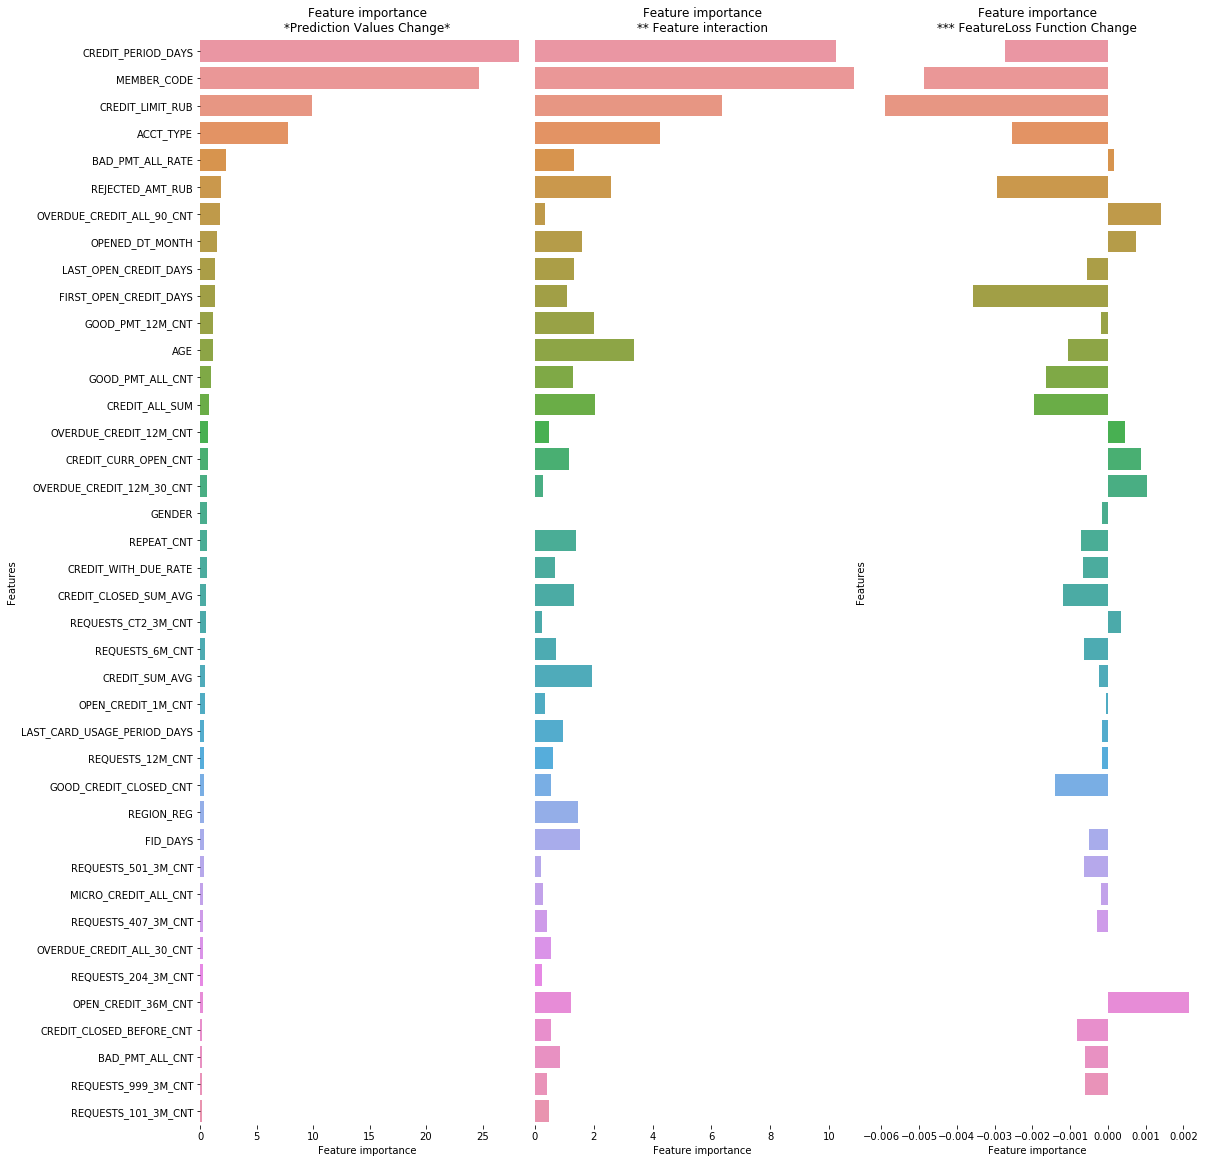

* For each feature, PredictionValuesChange shows how much on average the prediction changes     if the feature value changes. The bigger the value of the importance the bigger on average is the     change to the prediction value, if this feature is changed

Feature importance values are normalized so that the sum of importances of all features is equal     to 100. This is possible because the values of these importances are always non-negative.

Formula values inside different groups may vary significantly in ranking modes.     This might lead to high importance values for some groupwise features, even though these     features dont have a large impact on the resulting metric value.

** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2

*** For each feature the value represents the difference between the loss value of the model with this     feature and without it. The model without this feature is equivalen

In [28]:
# Вывод важности факторов для модели catboost
model = all_with_mс
model.plot_catb_feature_importance(model.models[0]['feature_importance'], top_n=40)

## Предсказания модели на отложенных выборках обучающего датасета

In [29]:
%%time
print('Запуск ', now_str())

# Качество предсказаний в разрезе продуктов на отложенной / тестовой выборке:
print('Предсказания модели на отложенных выборках обучающего датасета')

model = all_with_mс

slice_index = df.index

report_by_product(df=df.loc[slice_index], 
                  y_true=df[TARGET_NAME].loc[slice_index], 
                  y_proba=model.train_result['proba'].loc[slice_index])

Запуск  2020-03-07 18:54:11
Предсказания модели на отложенных выборках обучающего датасета

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)              18840734   4.41%    0.3655    0.8656      0.2317    0.9447    0.8894
Кредит на автомобиль (1)                  854305   1.01%    0.2141    0.6296       0.129    0.9233    0.8466
Кредитная карта (7)                      9556877   2.56%     0.362     0.891      0.2271    0.9687    0.9374
Ипотека (6)                               935381   0.29%    0.2191     0.522      0.1387    0.9414    0.8828
Все продукты                            30187297   3.60%    0.3629    0.8686      0.2293    0.9542    0.9084

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               9047280   2.46%    0.2609    0.7598      0.1575     0.917     0.834
Кредит на ав

## Валидация модели на независимых данных

In [30]:
%%time
print('Запуск ', now_str())

# Формирование предсказаний по данным
model = all_with_mс

all_with_mс_test_resul = model.predict(input_type='df',input_data=df_test, output_type='df')

Запуск  2020-03-07 19:03:24
Wall time: 3min 22s


In [31]:
%%time
print('Запуск ', now_str())

slice_index = df_test.index

report_by_product(df=df_test.loc[slice_index], 
                  y_true=df_test[TARGET_NAME].loc[slice_index], 
                  y_proba=all_with_mс_test_resul['proba'].loc[slice_index])

Запуск  2020-03-07 19:06:46

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               3428385   4.08%    0.3194    0.7564      0.2024    0.9072    0.8144
Кредитная карта (7)                      1778479   3.46%    0.4912    0.8339      0.3481    0.9667    0.9334
Кредит на автомобиль (1)                  134625   1.36%     0.239    0.6103      0.1486    0.9173    0.8346
Ипотека (6)                               138682   0.29%     0.203    0.4591      0.1303    0.9325     0.865
Все продукты                             5480171   3.72%    0.3589    0.7779      0.2333    0.9315     0.863

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               1522492   2.93%     0.279    0.6771      0.1757    0.8944    0.7888
Кредитная карта (7)                       710720   2.16%    0.3648    0.725

## **Модель: ТОП 40 признаков + MEMBER_CODE**

In [32]:
#Ретиинг признаков для формирования модели
print('\n'.join(list(all_with_mс.models[0]['feature_importance'].head(40).index)))

CREDIT_PERIOD_DAYS
MEMBER_CODE
CREDIT_LIMIT_RUB
ACCT_TYPE
BAD_PMT_ALL_RATE
REJECTED_AMT_RUB
OVERDUE_CREDIT_ALL_90_CNT
OPENED_DT_MONTH
LAST_OPEN_CREDIT_DAYS
FIRST_OPEN_CREDIT_DAYS
GOOD_PMT_12M_CNT
AGE
GOOD_PMT_ALL_CNT
CREDIT_ALL_SUM
OVERDUE_CREDIT_12M_CNT
CREDIT_CURR_OPEN_CNT
OVERDUE_CREDIT_12M_30_CNT
GENDER
REPEAT_CNT
CREDIT_WITH_DUE_RATE
CREDIT_CLOSED_SUM_AVG
REQUESTS_CT2_3M_CNT
REQUESTS_6M_CNT
CREDIT_SUM_AVG
OPEN_CREDIT_1M_CNT
LAST_CARD_USAGE_PERIOD_DAYS
REQUESTS_12M_CNT
GOOD_CREDIT_CLOSED_CNT
REGION_REG
FID_DAYS
REQUESTS_501_3M_CNT
MICRO_CREDIT_ALL_CNT
REQUESTS_407_3M_CNT
OVERDUE_CREDIT_ALL_30_CNT
REQUESTS_204_3M_CNT
OPEN_CREDIT_36M_CNT
CREDIT_CLOSED_BEFORE_CNT
BAD_PMT_ALL_CNT
REQUESTS_999_3M_CNT
REQUESTS_101_3M_CNT


In [33]:
# подготовка моделей

df_alt = df[list(all_with_mс.models[0]['feature_importance'].head(40).index) + [TARGET_NAME]] 

catbm = catb.CatBoostClassifier(eval_metric='AUC',
                                silent=True,
                                iterations=1000,
                                random_state=21)


models = {'catbm':catbm}

top40_with_mс = bank_90_model_dev(df=df_alt,                          # датасет
                                  TARGET_NAME = TARGET_NAME,            # Имя столбца с целевой переменной
                                  model_type='classification',          # тип модели :  'classification', 'regression'
                                  models=models,                        # словарь моделей (обязательно  должны быть методы fit, predict)   
                                  cat_columns=cat_columns,              # Названия столбцов с категориальными признакми
                                  scaler_columns=scaler_columns,        # Названия столбцов по которым необходимо проводить масштабирование
                                  scaler_type='std',                    # Тип масштабирования признаков ('none', 'std', 'norm')
                                  target_class_ratio=0.2,               # коэффициент для балансровки соотношения классов целевой переменной
                                  downsample=True,                      # при щначении True балансирвка осуществляется через downsampling 
                                  SKF_splits=5,                         # кол-во фолдов для валидации
                                  strat_layers_qty=10,                  # Кол-во слоев для стратификации датасета по целевой переменной при применении k-fold
                                  catb_sample_weight=True,              # указание веса каждого наблюдения для модели CatboostClassifier 
                                  random_state=42)                      # Random_State

In [34]:
%%time
print('Запуск ', now_str())

# Обучение модели
top40_with_mс.fit()

# Сохранение обученой модели
top40_with_mс.save(file_name=PATH_TO_MODEL + 'top40_with_mс', prod_mode=False)
top40_with_mс.save(file_name=PATH_TO_MODEL + 'top40_with_mс' + '_prod', prod_mode=True)

Запуск  2020-03-07 19:08:12

FOLD 1 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_1_valid                            1086150  20.00%    0.7494    0.8675      0.6596    0.9533    0.9066

FOLD 2 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_2_valid                            1086150  20.00%    0.7487    0.8674      0.6586    0.9528    0.9056

FOLD 3 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_3_valid                            1086150  20.00%    0.7495     0.869      0.6589    0.9534    0.9068

FOLD 4 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_4_valid                            1086150  20.00%    0.7494    0.8687      0.6589    0.9533    0.9066

FOLD 5 REPORT
Model                    

## Анализ работы модели и ключевых факторов

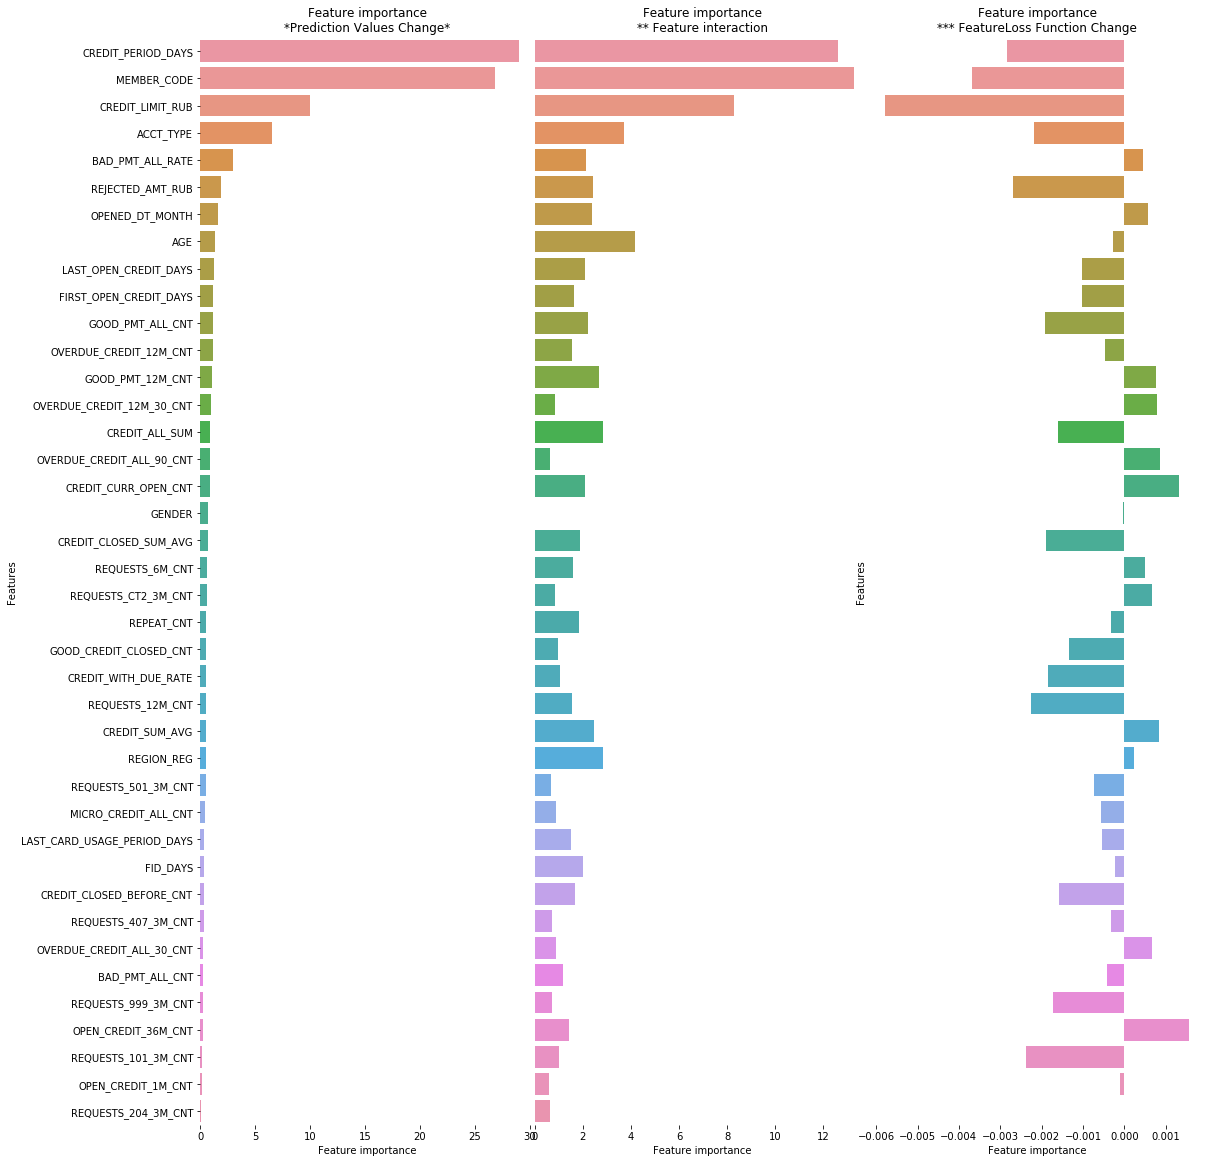

* For each feature, PredictionValuesChange shows how much on average the prediction changes     if the feature value changes. The bigger the value of the importance the bigger on average is the     change to the prediction value, if this feature is changed

Feature importance values are normalized so that the sum of importances of all features is equal     to 100. This is possible because the values of these importances are always non-negative.

Formula values inside different groups may vary significantly in ranking modes.     This might lead to high importance values for some groupwise features, even though these     features dont have a large impact on the resulting metric value.

** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2

*** For each feature the value represents the difference between the loss value of the model with this     feature and without it. The model without this feature is equivalen

In [35]:
# Вывод важности факторов для модели catboost
model = top40_with_mс
model.plot_catb_feature_importance(model.models[0]['feature_importance'], top_n=40)

## Предсказания модели на отложенных выборках обучающего датасета

In [36]:
%%time
print('Запуск ', now_str())

# Качество предсказаний в разрезе продуктов на отложенной / тестовой выборке:
print('Предсказания модели на отложенных выборках обучающего датасета')

model = top40_with_mс

slice_index = df.index

report_by_product(df=df.loc[slice_index], 
                  y_true=df[TARGET_NAME].loc[slice_index], 
                  y_proba=model.train_result['proba'].loc[slice_index])

Запуск  2020-03-07 23:17:32
Предсказания модели на отложенных выборках обучающего датасета

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)              18840734   4.41%    0.3607    0.8645      0.2279    0.9437    0.8874
Кредит на автомобиль (1)                  854305   1.01%     0.205    0.6327      0.1223    0.9214    0.8428
Кредитная карта (7)                      9556877   2.56%    0.3611    0.8923      0.2264    0.9689    0.9378
Ипотека (6)                               935381   0.29%    0.2161    0.5177      0.1366     0.938     0.876
Все продукты                            30187297   3.60%    0.3589     0.868      0.2262    0.9536    0.9072

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               9047280   2.46%    0.2569    0.7576      0.1547    0.9153    0.8306
Кредит на ав

## Валидация модели на независимых данных

In [37]:
%%time
print('Запуск ', now_str())

# Формирование предсказаний по данным
model = top40_with_mс

top40_with_mс_test_resul = model.predict(input_type='df',input_data=df_test, output_type='df')

Запуск  2020-03-07 23:25:39
Wall time: 1min 33s


In [38]:
%%time
print('Запуск ', now_str())

slice_index = df_test.index

report_by_product(df=df_test.loc[slice_index], 
                  y_true=df_test[TARGET_NAME].loc[slice_index], 
                  y_proba=all_with_mс_test_resul['proba'].loc[slice_index])

Запуск  2020-03-07 23:27:13

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               3428385   4.08%    0.3194    0.7564      0.2024    0.9072    0.8144
Кредитная карта (7)                      1778479   3.46%    0.4912    0.8339      0.3481    0.9667    0.9334
Кредит на автомобиль (1)                  134625   1.36%     0.239    0.6103      0.1486    0.9173    0.8346
Ипотека (6)                               138682   0.29%     0.203    0.4591      0.1303    0.9325     0.865
Все продукты                             5480171   3.72%    0.3589    0.7779      0.2333    0.9315     0.863

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               1522492   2.93%     0.279    0.6771      0.1757    0.8944    0.7888
Кредитная карта (7)                       710720   2.16%    0.3648    0.725

## **Модель: все признаки без MEMBER_CODE (отбор признаков)**

In [39]:
# подготовка моделей

catbm = catb.CatBoostClassifier(eval_metric='AUC',
                                silent=True,
                                iterations=1000,
                                random_state=21)


models = {'catbm':catbm}

all_no_mс = bank_90_model_dev(df=df.drop(columns='MEMBER_CODE'),  # датасет
                              TARGET_NAME = TARGET_NAME,            # Имя столбца с целевой переменной
                              model_type='classification',          # тип модели :  'classification', 'regression'
                              models=models,                        # словарь моделей (обязательно  должны быть методы fit, predict)   
                              cat_columns=cat_columns,              # Названия столбцов с категориальными признакми
                              scaler_columns=scaler_columns,        # Названия столбцов по которым необходимо проводить масштабирование
                              scaler_type='std',                    # Тип масштабирования признаков ('none', 'std', 'norm')
                              target_class_ratio=0.2,               # коэффициент для балансровки соотношения классов целевой переменной
                              downsample=True,                      # при щначении True балансирвка осуществляется через downsampling 
                              SKF_splits=5,                         # кол-во фолдов для валидации
                              strat_layers_qty=10,                  # Кол-во слоев для стратификации датасета по целевой переменной при применении k-fold
                              catb_sample_weight=True,              # указание веса каждого наблюдения для модели CatboostClassifier 
                              random_state=42)                      # Random_State

In [40]:
%%time
print('Запуск ', now_str())

# Обучение модели
all_no_mс.fit()

# Сохранение обученой модели
all_no_mс.save(file_name=PATH_TO_MODEL + 'all_no_mс', prod_mode=False)
all_no_mс.save(file_name=PATH_TO_MODEL + 'all_no_mс' + '_prod', prod_mode=True)

Запуск  2020-03-07 23:29:17

FOLD 1 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_1_valid                            1086150  20.00%    0.7215    0.8341      0.6357    0.9364    0.8728

FOLD 2 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_2_valid                            1086150  20.00%    0.7212    0.8327       0.636     0.936     0.872

FOLD 3 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_3_valid                            1086150  20.00%    0.7216    0.8347      0.6355    0.9364    0.8728

FOLD 4 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_4_valid                            1086150  20.00%      0.72    0.8346      0.6331    0.9363    0.8726

FOLD 5 REPORT
Model                    

## Анализ работы модели и ключевых факторов

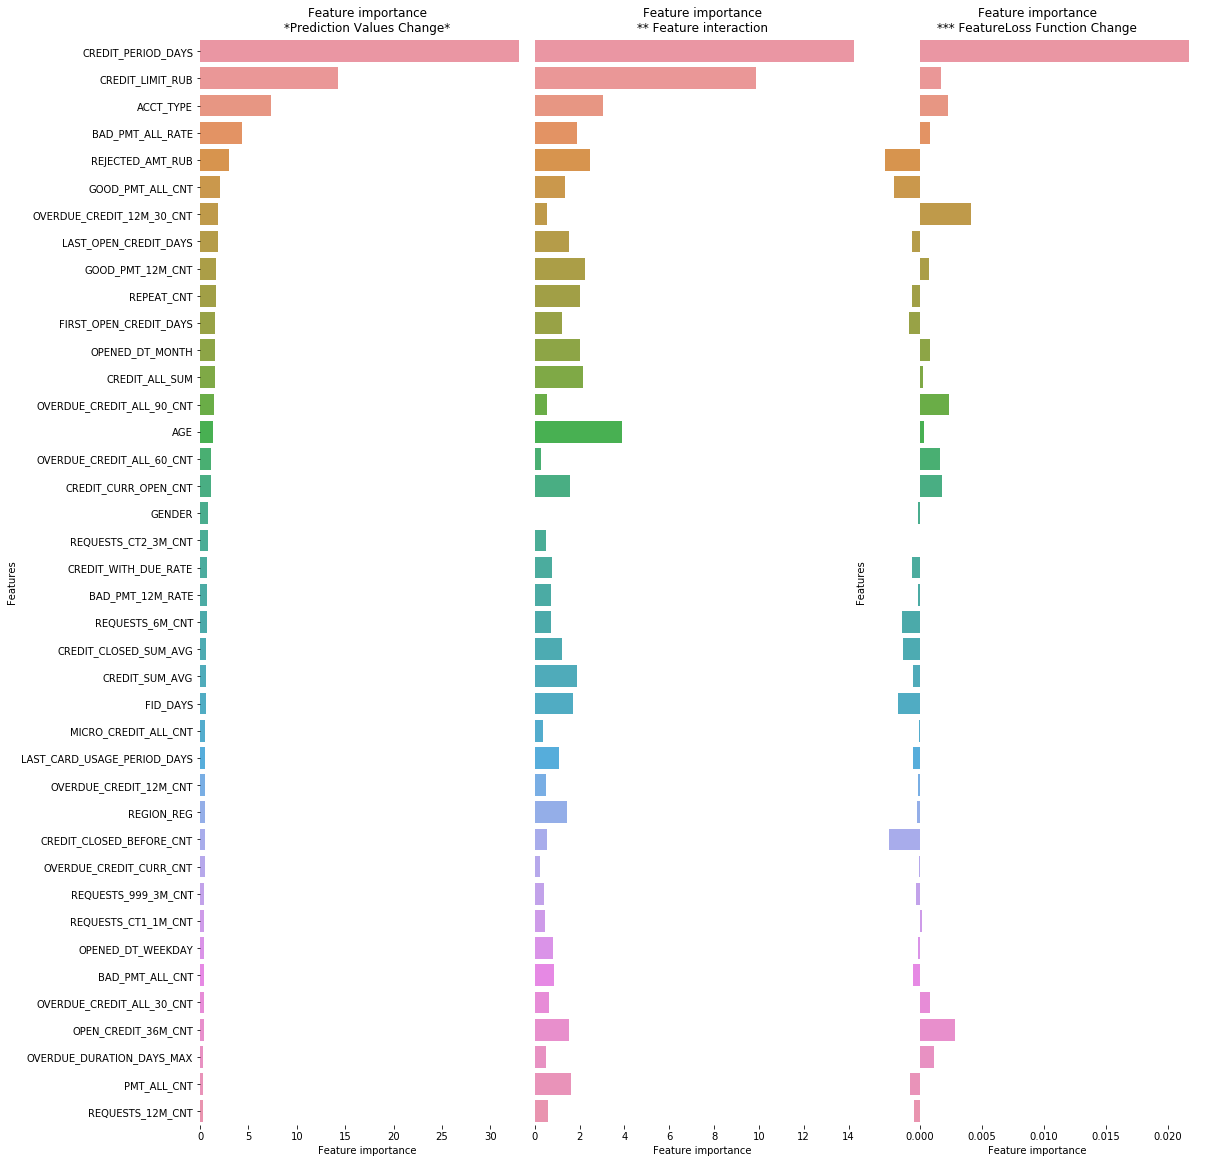

* For each feature, PredictionValuesChange shows how much on average the prediction changes     if the feature value changes. The bigger the value of the importance the bigger on average is the     change to the prediction value, if this feature is changed

Feature importance values are normalized so that the sum of importances of all features is equal     to 100. This is possible because the values of these importances are always non-negative.

Formula values inside different groups may vary significantly in ranking modes.     This might lead to high importance values for some groupwise features, even though these     features dont have a large impact on the resulting metric value.

** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2

*** For each feature the value represents the difference between the loss value of the model with this     feature and without it. The model without this feature is equivalen

In [41]:
# Вывод важности факторов для модели catboost
model = all_no_mс
model.plot_catb_feature_importance(model.models[0]['feature_importance'], top_n=40)

## Предсказания модели на отложенных выборках обучающего датасета

In [42]:
%%time
print('Запуск ', now_str())

# Качество предсказаний в разрезе продуктов на отложенной / тестовой выборке:
print('Предсказания модели на отложенных выборках обучающего датасета')

model = all_no_mс

slice_index = df.index

report_by_product(df=df.loc[slice_index], 
                  y_true=df[TARGET_NAME].loc[slice_index], 
                  y_proba=model.train_result['proba'].loc[slice_index])

Запуск  2020-03-08 04:57:25
Предсказания модели на отложенных выборках обучающего датасета

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)              18840734   4.41%     0.342    0.8369      0.2149    0.9281    0.8562
Кредит на автомобиль (1)                  854305   1.01%    0.1786    0.5199      0.1079    0.8932    0.7864
Кредитная карта (7)                      9556877   2.56%    0.3144    0.8388      0.1935    0.9477    0.8954
Ипотека (6)                               935381   0.29%    0.1836    0.4681      0.1142    0.9198    0.8396
Все продукты                            30187297   3.60%    0.3335    0.8339      0.2084    0.9366    0.8732

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               9047280   2.46%    0.2373     0.718      0.1422     0.893     0.786
Кредит на ав

## Валидация модели на независимых данных

In [43]:
%%time
print('Запуск ', now_str())

# Формирование предсказаний по данным
model = all_no_mс

all_no_mс_test_resul = model.predict(input_type='df',input_data=df_test, output_type='df')

Запуск  2020-03-08 05:07:01
Wall time: 2min 55s


In [44]:
%%time
print('Запуск ', now_str())

slice_index = df_test.index

report_by_product(df=df_test.loc[slice_index], 
                  y_true=df_test[TARGET_NAME].loc[slice_index], 
                  y_proba=all_no_mс_test_resul['proba'].loc[slice_index])

Запуск  2020-03-08 05:09:56

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               3428385   4.08%    0.3004    0.7481      0.1879    0.8956    0.7912
Кредитная карта (7)                      1778479   3.46%    0.3714    0.7695      0.2448    0.9314    0.8628
Кредит на автомобиль (1)                  134625   1.36%    0.2263    0.5551      0.1421    0.9043    0.8086
Ипотека (6)                               138682   0.29%    0.1579    0.4342      0.0965    0.9193    0.8386
Все продукты                             5480171   3.72%    0.3182    0.7522      0.2018    0.9104    0.8208

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               1522492   2.93%    0.2594    0.6544      0.1618    0.8777    0.7554
Кредитная карта (7)                       710720   2.16%    0.2744    0.623

## **Модель: ТОП 40 признаков без MEMBER_CODE**

In [45]:
#Ретиинг признаков для формирования модели
print('\n'.join(list(all_no_mс.models[0]['feature_importance'].head(40).index)))

CREDIT_PERIOD_DAYS
CREDIT_LIMIT_RUB
ACCT_TYPE
BAD_PMT_ALL_RATE
REJECTED_AMT_RUB
GOOD_PMT_ALL_CNT
OVERDUE_CREDIT_12M_30_CNT
LAST_OPEN_CREDIT_DAYS
GOOD_PMT_12M_CNT
REPEAT_CNT
FIRST_OPEN_CREDIT_DAYS
OPENED_DT_MONTH
CREDIT_ALL_SUM
OVERDUE_CREDIT_ALL_90_CNT
AGE
OVERDUE_CREDIT_ALL_60_CNT
CREDIT_CURR_OPEN_CNT
GENDER
REQUESTS_CT2_3M_CNT
CREDIT_WITH_DUE_RATE
BAD_PMT_12M_RATE
REQUESTS_6M_CNT
CREDIT_CLOSED_SUM_AVG
CREDIT_SUM_AVG
FID_DAYS
MICRO_CREDIT_ALL_CNT
LAST_CARD_USAGE_PERIOD_DAYS
OVERDUE_CREDIT_12M_CNT
REGION_REG
CREDIT_CLOSED_BEFORE_CNT
OVERDUE_CREDIT_CURR_CNT
REQUESTS_999_3M_CNT
REQUESTS_CT1_1M_CNT
OPENED_DT_WEEKDAY
BAD_PMT_ALL_CNT
OVERDUE_CREDIT_ALL_30_CNT
OPEN_CREDIT_36M_CNT
OVERDUE_DURATION_DAYS_MAX
PMT_ALL_CNT
REQUESTS_12M_CNT


In [46]:
# подготовка моделей

df_alt = df[list(all_no_mс.models[0]['feature_importance'].head(40).index) + [TARGET_NAME]] 

catbm = catb.CatBoostClassifier(eval_metric='AUC',
                                silent=True,
                                iterations=1000,
                                random_state=21)


models = {'catbm':catbm}

top40_no_mс = bank_90_model_dev(df=df_alt,                          # датасет
                                TARGET_NAME = TARGET_NAME,            # Имя столбца с целевой переменной
                                model_type='classification',          # тип модели :  'classification', 'regression'
                                models=models,                        # словарь моделей (обязательно  должны быть методы fit, predict)   
                                cat_columns=cat_columns,              # Названия столбцов с категориальными признакми
                                scaler_columns=scaler_columns,        # Названия столбцов по которым необходимо проводить масштабирование
                                scaler_type='std',                    # Тип масштабирования признаков ('none', 'std', 'norm')
                                target_class_ratio=0.2,               # коэффициент для балансровки соотношения классов целевой переменной
                                downsample=True,                      # при щначении True балансирвка осуществляется через downsampling 
                                SKF_splits=5,                         # кол-во фолдов для валидации
                                strat_layers_qty=10,                  # Кол-во слоев для стратификации датасета по целевой переменной при применении k-fold
                                catb_sample_weight=True,              # указание веса каждого наблюдения для модели CatboostClassifier 
                                random_state=42)                      # Random_State

In [47]:
%%time
print('Запуск ', now_str())

# Обучение модели
top40_no_mс.fit()

# Сохранение обученой модели
top40_no_mс.save(file_name=PATH_TO_MODEL + 'top40_no_mс', prod_mode=False)
top40_no_mс.save(file_name=PATH_TO_MODEL + 'top40_no_mс' + '_prod', prod_mode=True)

Запуск  2020-03-08 05:11:28

FOLD 1 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_1_valid                            1086150  20.00%    0.7178    0.8304      0.6321    0.9345     0.869

FOLD 2 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_2_valid                            1086150  20.00%    0.7172      0.83      0.6313    0.9342    0.8684

FOLD 3 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_3_valid                            1086150  20.00%    0.7174    0.8316      0.6308    0.9347    0.8694

FOLD 4 REPORT
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
catbm_4_valid                            1086150  20.00%    0.7175    0.8314      0.6311    0.9349    0.8698

FOLD 5 REPORT
Model                    

## Анализ работы модели и ключевых факторов

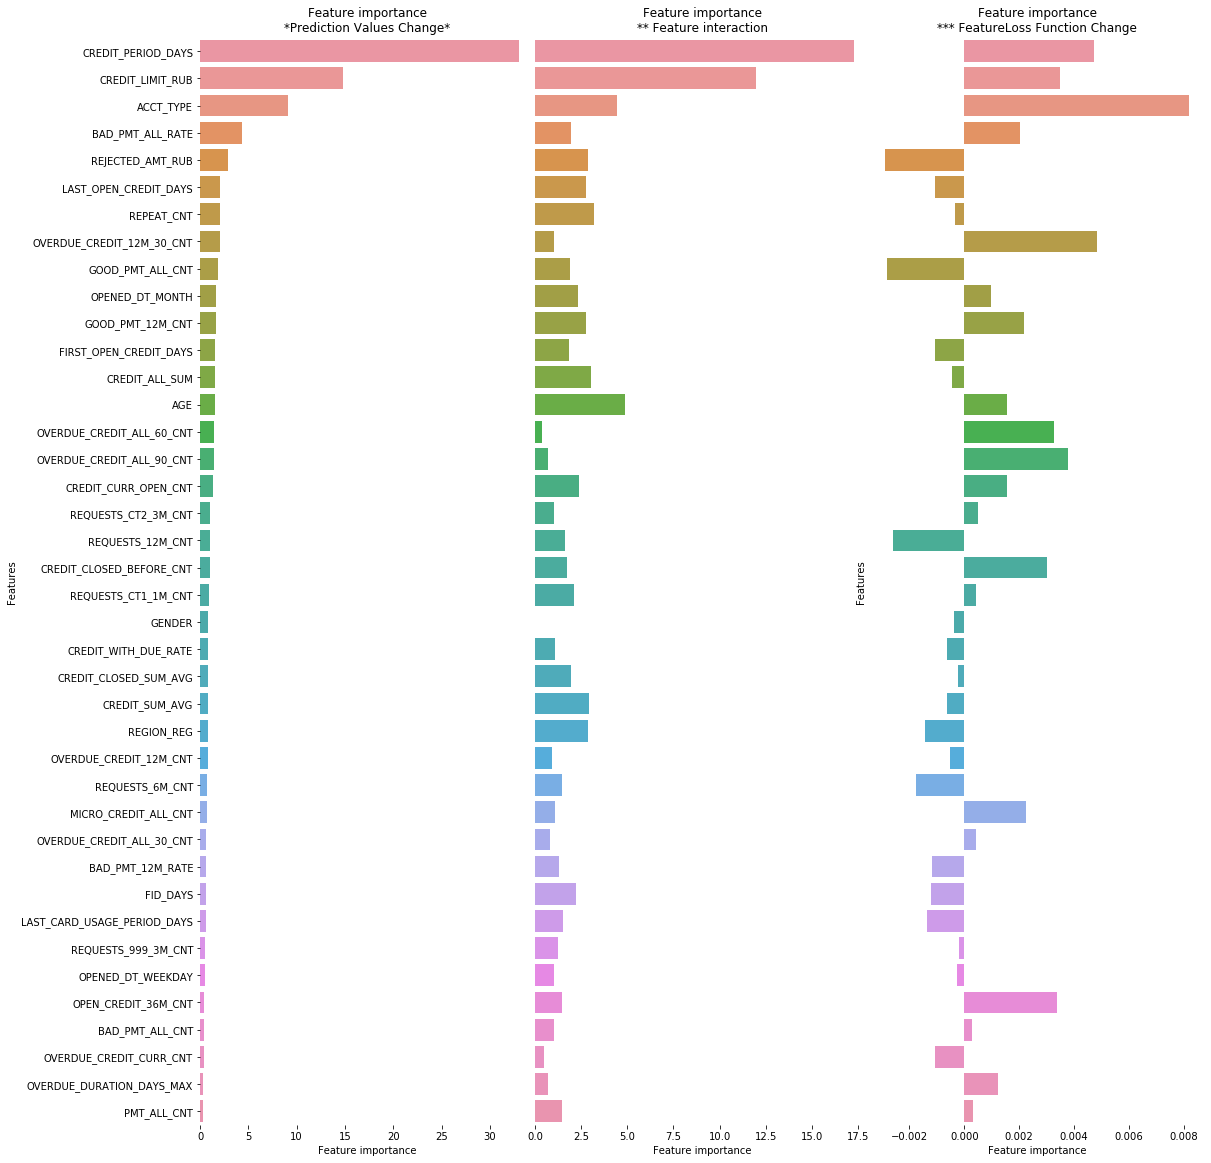

* For each feature, PredictionValuesChange shows how much on average the prediction changes     if the feature value changes. The bigger the value of the importance the bigger on average is the     change to the prediction value, if this feature is changed

Feature importance values are normalized so that the sum of importances of all features is equal     to 100. This is possible because the values of these importances are always non-negative.

Formula values inside different groups may vary significantly in ranking modes.     This might lead to high importance values for some groupwise features, even though these     features dont have a large impact on the resulting metric value.

** TTL Sum for feature interaction is 100. Calculated as sum of importance of all paired combination with given factor devided by 2

*** For each feature the value represents the difference between the loss value of the model with this     feature and without it. The model without this feature is equivalen

In [48]:
# Вывод важности факторов для модели catboost
model = top40_no_mс
model.plot_catb_feature_importance(model.models[0]['feature_importance'], top_n=40)

## Предсказания модели на отложенных выборках обучающего датасета

In [49]:
%%time
print('Запуск ', now_str())

# Качество предсказаний в разрезе продуктов на отложенной / тестовой выборке:
print('Предсказания модели на отложенных выборках обучающего датасета')

model = top40_no_mс

slice_index = df.index

report_by_product(df=df.loc[slice_index], 
                  y_true=df[TARGET_NAME].loc[slice_index], 
                  y_proba=model.train_result['proba'].loc[slice_index])

Запуск  2020-03-08 08:57:39
Предсказания модели на отложенных выборках обучающего датасета

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)              18840734   4.41%     0.337    0.8343      0.2111    0.9261    0.8522
Кредит на автомобиль (1)                  854305   1.01%    0.1737    0.4999      0.1051    0.8867    0.7734
Кредитная карта (7)                      9556877   2.56%     0.313    0.8348      0.1926    0.9465     0.893
Ипотека (6)                               935381   0.29%    0.1797    0.4528      0.1121    0.9149    0.8298
Все продукты                            30187297   3.60%    0.3294    0.8308      0.2054    0.9349    0.8698

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               9047280   2.46%    0.2331    0.7114      0.1394    0.8895     0.779
Кредит на ав

## Валидация модели на независимых данных

In [50]:
%%time
print('Запуск ', now_str())

# Формирование предсказаний по данным
model = top40_no_mс

top40_no_mс_test_resul = model.predict(input_type='df',input_data=df_test, output_type='df')

Запуск  2020-03-08 09:06:29
Wall time: 1min 12s


In [51]:
%%time
print('Запуск ', now_str())

slice_index = df_test.index

report_by_product(df=df_test.loc[slice_index], 
                  y_true=df_test[TARGET_NAME].loc[slice_index], 
                  y_proba=top40_no_mс_test_resul['proba'].loc[slice_index])

Запуск  2020-03-08 09:07:41

ВСЕ ЗАЕМЩИКИ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               3428385   4.08%    0.2937    0.7409      0.1832     0.891     0.782
Кредитная карта (7)                      1778479   3.46%    0.3545    0.7532      0.2318    0.9252    0.8504
Кредит на автомобиль (1)                  134625   1.36%     0.202    0.5202      0.1253    0.8944    0.7888
Ипотека (6)                               138682   0.29%    0.1482    0.4293      0.0895    0.9138    0.8276
Все продукты                             5480171   3.72%    0.3087     0.742      0.1949    0.9051    0.8102

ПОВТОРНЫЕ
Model                                        Qty     1 %  f1 score    Recall  Precission   ROC AUC      Gini
Потребительский кредит (9)               1522492   2.93%     0.253    0.6441      0.1574    0.8718    0.7436
Кредитная карта (7)                       710720   2.16%     0.261    0.604

# **ЗАГРУЗКА PROD МОДЕЛЕЙ**

In [52]:
# Открытие модели из файла
prod_model_dict = {
                   'top40_with_mс_prod':'top40_with_mс_prod',
                   'top40_no_mс_prod':'top40_no_mс_prod'
                    }

for prod_model_name in prod_model_dict.keys(): 
    f_name = PATH_TO_MODEL + prod_model_name
    with open(f_name, 'rb') as f:
        vars()[prod_model_dict[prod_model_name]] = pickle.load(f)

In [53]:
%%time
print('Запуск ', now_str())

# Формирование прогноза
top40_with_mс_prod_test_result = top40_with_mс_prod.predict(input_type='df',input_data=df_test, output_type='df')
top40_no_mс_prod_test_result = top40_no_mс_prod.predict(input_type='df',input_data=df_test, output_type='df')

Запуск  2020-03-08 09:09:13
Wall time: 2min 43s


# **ОТЧЕТ ПО ВАЛИДАЦИИ МОДЕЛЕЙ**

In [54]:
df_test['top40_with_mc_proba'] = top40_with_mс_prod_test_result['proba']
df_test['top40_no_mc_proba'] = top40_no_mс_prod_test_result['proba']

In [55]:
%%time
print('Запуск ', now_str())

# Формирование отчета по срезам

df_report = df_test
report_file_name = 'MODELS_validation.xlsx'

slice_dict = {
              'TTL': df_report[(df_report['OPENED_DT'] >= '2018-12-01') & (df_report['OPENED_DT'] <= '2019-01-31')].index,
              '2018.12.01-07': df_report[(df_report['OPENED_DT'] >= '2018-12-01') & (df_report['OPENED_DT'] <= '2018-12-07')].index,
              '2018.12.08-14': df_report[(df_report['OPENED_DT'] >= '2018-12-08') & (df_report['OPENED_DT'] <= '2018-12-14')].index,
              '2018.12.15-21': df_report[(df_report['OPENED_DT'] >= '2018-12-15') & (df_report['OPENED_DT'] <= '2018-12-21')].index,
              '2018.12.22-31': df_report[(df_report['OPENED_DT'] >= '2018-12-22') & (df_report['OPENED_DT'] <= '2018-12-31')].index,
              '2019.01.01-14': df_report[(df_report['OPENED_DT'] >= '2019-01-01') & (df_report['OPENED_DT'] <= '2019-01-14')].index,
              '2019.01.15-21': df_report[(df_report['OPENED_DT'] >= '2019-01-15') & (df_report['OPENED_DT'] <= '2019-01-21')].index,
              '2019.01.22-31': df_report[(df_report['OPENED_DT'] >= '2019-01-22') & (df_report['OPENED_DT'] <= '2019-01-31')].index,
              }

y_proba = {
           'Top 40 factors with MC': df_report['top40_with_mc_proba'],
           'Top 40 factors no MC':df_report['top40_no_mc_proba']
           }

metrics_report, score_report = slice_report(df=df_report,
                                            y_true=df_report[TARGET_NAME],
                                            credit_amt=df_report['CREDIT_LIMIT_RUB'],
                                            y_proba=y_proba,
                                            slice_dict=slice_dict,
                                            feature_list=['MAIN_MEMBER_CODE', 'REPEAT','ACCT_TYPE'])

metrics_report['ACCT_TYPE'] = metrics_report['ACCT_TYPE'].map(product_dict)
score_report['ACCT_TYPE'] = score_report['ACCT_TYPE'].map(product_dict)

metrics_report['REPEAT'] = metrics_report['REPEAT'].map(new_repead_dict)
score_report['REPEAT'] = score_report['REPEAT'].map(new_repead_dict)

metrics_report['MEMBER_NAME'] = metrics_report['MAIN_MEMBER_CODE'].map(member_code_dict)
metrics_report['MEMBER_NAME'].fillna(metrics_report['MAIN_MEMBER_CODE'], inplace=True)

score_report['MEMBER_NAME'] = score_report['MAIN_MEMBER_CODE'].map(member_code_dict)
score_report['MEMBER_NAME'].fillna(score_report['MAIN_MEMBER_CODE'], inplace=True)

print('Экспорт данных...')

writer = pd.ExcelWriter(PATH_TO_MODEL + report_file_name)
metrics_report.to_excel(writer, sheet_name='metrics', engine='io.excel.xlsx.writer')
score_report[score_report['report_type']=='score bucket'].to_excel(writer, sheet_name='scoring', engine='io.excel.xlsx.writer')
score_report[score_report['report_type']=='percentile qty'].to_excel(writer, sheet_name='percentile qty', engine='io.excel.xlsx.writer')
score_report[score_report['report_type']=='percentile amt'].to_excel(writer, sheet_name='percentile amt', engine='io.excel.xlsx.writer')
writer.save()

print('Данные экспортированы в файл ', report_file_name)

Запуск  2020-03-08 09:11:56
Экспорт данных...
Данные экспортированы в файл  MODELS_validation.xlsx
Wall time: 12h 48min 58s


# **FICO**

In [56]:
%%time
print('Запуск ', now_str())

# Загрузка тестового датасета
fico_list = ['FICO_201812.csv',
             'FICO_201901.csv']

for fico_file_name in fico_list:
    print('Загрузка:', fico_file_name)
    fico_result_add = pd.read_csv(PATH_TO_FICO + fico_file_name, sep='\t')

    if fico_file_name == fico_list[0]:
        fico_result = fico_result_add
    else:
        fico_result = pd.concat((fico_result, fico_result_add), axis=0)
    
    del(fico_result_add)
    
fico_result.index = np.arange(fico_result.shape[0])

Запуск  2020-03-08 22:00:54
Загрузка: FICO_201812.csv
Загрузка: FICO_201901.csv
Wall time: 6.79 s


In [57]:
%%time
print('Запуск ', now_str())

# Обработака данных FICO
fico_result['Score'][fico_result['Score'] == 300] = 301
fico_result['Score'][fico_result['Score'] == 850] = 849

fico_result['Retro_date'] = pd.to_datetime(fico_result['Retro_date'], format='%d.%m.%Y', errors='coerce')
fico_result = fico_result[fico_result['Score'] != 0]

fico_result['FICO_proba'] = 1 - (fico_result['Score'] - 300) / 550
fico_result['FID_OPENED_DT'] =  fico_result['FID'].astype('str') + '_' + fico_result['Retro_date'].astype('str')

fico_proba_dict = fico_result[['FID_OPENED_DT', 'FICO_proba']].set_index('FID_OPENED_DT')['FICO_proba'].to_dict()


df_test['FID_OPENED_DT'] = df_test['FID'].astype('str') + '_' + df_test['OPENED_DT'].astype('str')
df_test['FICO_proba'] = df_test['FID_OPENED_DT'].map(fico_proba_dict)
df_test['FICO_proba'].fillna(0, inplace=True)

df_test.drop(columns='FID_OPENED_DT', inplace=True)

del(fico_result)

print('TTL test data:{:>12}'.format(df_test.shape[0]))
print('FICO scored:{:>14}'.format(df_test[df_test['FICO_proba'] > 0].shape[0]))
print('FICO hitrate:{:>13.2%}'.format(df_test[df_test['FICO_proba'] > 0].shape[0] / df_test.shape[0]))

Запуск  2020-03-08 22:01:01
TTL test data:     5480171
FICO scored:       4250291
FICO hitrate:       77.56%
Wall time: 1min 4s


In [58]:
%%time
print('Запуск ', now_str())

# Формирование отчета
df_report = df_test
report_file_name = 'FICO_comparison.xlsx'

slice_dict = {
              'FICO Hit TTL': df_report[(df_report['OPENED_DT'] >= '2018-12-01') & (df_report['OPENED_DT'] <= '2019-01-31') & (df_report['FICO_proba'] > 0)].index,
              'FICO Hit 2018.12.01-07': df_report[(df_report['OPENED_DT'] >= '2018-12-01') & (df_report['OPENED_DT'] <= '2018-12-07') & (df_report['FICO_proba'] > 0)].index,
              'FICO Hit 2018.12.08-14': df_report[(df_report['OPENED_DT'] >= '2018-12-08') & (df_report['OPENED_DT'] <= '2018-12-14') & (df_report['FICO_proba'] > 0)].index,
              'FICO Hit 2018.12.15-21': df_report[(df_report['OPENED_DT'] >= '2018-12-15') & (df_report['OPENED_DT'] <= '2018-12-21') & (df_report['FICO_proba'] > 0)].index,
              'FICO Hit 2018.12.22-31': df_report[(df_report['OPENED_DT'] >= '2018-12-22') & (df_report['OPENED_DT'] <= '2018-12-31') & (df_report['FICO_proba'] > 0)].index,
              'FICO Hit 2019.01.01-14': df_report[(df_report['OPENED_DT'] >= '2019-01-01') & (df_report['OPENED_DT'] <= '2019-01-14') & (df_report['FICO_proba'] > 0)].index,
              'FICO Hit 2019.01.15-21': df_report[(df_report['OPENED_DT'] >= '2019-01-15') & (df_report['OPENED_DT'] <= '2019-01-21') & (df_report['FICO_proba'] > 0)].index,
              'FICO Hit 2019.01.22-31': df_report[(df_report['OPENED_DT'] >= '2019-01-22') & (df_report['OPENED_DT'] <= '2019-01-31') & (df_report['FICO_proba'] > 0)].index,
              }

y_proba = {'Top 40 factors with MC': df_report['top40_with_mc_proba'],
           'Top 40 factors no MC':df_report['top40_no_mc_proba'],
           'FICO Score':df_report['FICO_proba']}

metrics_report, score_report = slice_report(df=df_report,
                                            y_true=df_report[TARGET_NAME],
                                            credit_amt=df_report['CREDIT_LIMIT_RUB'],
                                            y_proba=y_proba,
                                            slice_dict=slice_dict,
                                            feature_list=['MAIN_MEMBER_CODE', 'REPEAT','ACCT_TYPE'])

metrics_report['ACCT_TYPE'] = metrics_report['ACCT_TYPE'].map(product_dict)
score_report['ACCT_TYPE'] = score_report['ACCT_TYPE'].map(product_dict)

metrics_report['REPEAT'] = metrics_report['REPEAT'].map(new_repead_dict)
score_report['REPEAT'] = score_report['REPEAT'].map(new_repead_dict)

metrics_report['MEMBER_NAME'] = metrics_report['MAIN_MEMBER_CODE'].map(member_code_dict)
metrics_report['MEMBER_NAME'].fillna(metrics_report['MAIN_MEMBER_CODE'], inplace=True)
score_report['MEMBER_NAME'] = score_report['MAIN_MEMBER_CODE'].map(member_code_dict)
score_report['MEMBER_NAME'].fillna(score_report['MAIN_MEMBER_CODE'], inplace=True)

print('Экспорт данных...')

writer = pd.ExcelWriter(PATH_TO_MODEL + report_file_name)
metrics_report.to_excel(writer, sheet_name='metrics', engine='io.excel.xlsx.writer')
score_report[score_report['report_type']=='score bucket'].to_excel(writer, sheet_name='scoring', engine='io.excel.xlsx.writer')
score_report[score_report['report_type']=='percentile qty'].to_excel(writer, sheet_name='percentile qty', engine='io.excel.xlsx.writer')
score_report[score_report['report_type']=='percentile amt'].to_excel(writer, sheet_name='percentile amt', engine='io.excel.xlsx.writer')
writer.save()

print('Данные экспортированы в файл ', report_file_name)

Запуск  2020-03-08 22:02:05
Экспорт данных...
Данные экспортированы в файл  FICO_comparison.xlsx
Wall time: 20h 1min 13s


In [59]:
print('Завершение ', now_str())

Завершение  2020-03-09 18:03:19
